[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zakizulham/proyek-peramalan-global-comodity-price-september-2024/blob/main/notebooks/3_Beyond_ARIMA_Model.ipynb)

# Beyond ARIMA: Mengatasi Non-Normalitas, Heteroskedastisitas, dan Musiman

Tujuan Notebook:

1. Mengeksplorasi SARIMA (Seasonal ARIMA)
2. Transformasi Data untuk Stabilisasi Varians
3. Pemodelan Volatilitas dengan ARCH/GARCH
4. VAR atau Kointegrasi
5. Evaluasi dan Perbandingan Model Lanjutan

Dari analisis yang telah dilakukan menggunakan model ARIMA(1,1,2) untuk memprediksi harga Crude Oil WTI:

1.  **Data Preprocessing:** Data berhasil dimuat, dibersihkan (mengatasi missing values dengan backward fill), dan diatur dengan indeks tanggal serta frekuensi harian.
2.  **EDA dan Stasioneritas:** Analisis awal menunjukkan data asli non-stasioner dengan adanya tren dan variansi yang tidak konstan. Proses differencing orde pertama berhasil membuat data menjadi stasioner, yang dikonfirmasi oleh Uji ADF. Analisis ACF dan PACF pada data yang didifferencing memberikan indikasi awal untuk ordo (p,q) model ARIMA.
3.  **Pemodelan ARIMA:** Model ARIMA(1,1,2) dipilih berdasarkan analisis ACF/PACF dan perbandingan dengan ordo lain berdasarkan kriteria informasi (AIC/BIC), menunjukkan kinerja yang relatif baik dalam menangkap struktur autokorelasi pada data latih.
4.  **Diagnostik Residual:**
    *   Uji Ljung-Box menunjukkan bahwa residual model menyerupai white noise, mengindikasikan bahwa model telah berhasil menangkap sebagian besar autokorelasi.
    *   Namun, uji Jarque-Bera dan visualisasi histogram menunjukkan bahwa residual **tidak berdistribusi secara normal**.
    *   Uji Heteroskedasticity (ARCH Test) menunjukkan adanya bukti **heteroskedastisitas** pada residual (varians tidak konstan). Temuan ini konsisten dengan observasi pada tahap EDA.
5. **Evaluasi Peramalan pada Data Uji:** Model ARIMA(1,1,2) mampu memberikan peramalan pada data uji. Kinerja model pada data uji dievaluasi menggunakan metrik berikut:
    *   Mean Absolute Error (MAE): 5.4927
    *   Mean Squared Error (MSE): 41.7104
    *   Root Mean Squared Error (RMSE): 6.4584
    *   Mean Absolute Percentage Error (MAPE): 6.9405%

    Seperti yang umum terjadi pada model ARIMA dasar untuk peramalan multi-langkah, prediksi cenderung menjadi konstan seiring bertambahnya periode peramalan. Metrik evaluasi memberikan gambaran kuantitatif tentang akurasi model pada data uji.

## Mengeksplorasi SARIMA (Seasonal ARIMA)

### Import Package dan Dataset

In [ ]:
# Import package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# Read dataframe
df = pd.read_csv('https://raw.githubusercontent.com/zakizulham/proyek-peramalan-global-comodity-price-september-2024/refs/heads/main/data/Arkavidiaa_Processed/Global_Commodity_Price/Crude_Oil_WTI.csv', parse_dates=['date'])
# Penyesuaian data sama seperti sebelumnya
df.sort_values(by='date', inplace=True)
df.set_index('date', inplace=True)
df = df.asfreq('D')
df = df.bfill()

# definisikan kolom target
target_column = 'price'

### Pemodelan SARIMA

Berdasarkan temuan kunci dari EDA dan pemodelan ARIMA, terutama konfirmasi non-stasioneritas yang berhasil diatasi dengan differencing (d=1) dan analisis struktur autokorelasi sisa melalui plot ACF/PACF, kita sekarang siap untuk melanjutkan ke section pemodelan.



#### 1. Menentukan Ordo (p, q, s) Model SARIMA

Berdasarkan analisis ACF dan PACF dari data yang telah didifferencing, kita perlu mengidentifikasi ordo p (autoregressive),n q (moving average), dan s (pola seasonal).

- Plot ACF membantu menentukan ordo $q$. Cari lag di mana fungsi autokorelasi secara signifikan cut off ke nol.
- Plot PACF membantu menentukan ordo $p$. Cari lag di mana fungsi autokorelasi parsial secara signifikan cut off ke nol.

Proses ini akan memerlukan beberapa percobaan dan evaluasi model yang berbeda.


**Untuk menampilkan plot ACF dan PACF dari data yang didifferencing:**

Pertama, kita perlu membuat deret waktu yang sudah didifferencing.

In [ ]:
# Membuat deret waktu yang sudah didifferencing orde pertama
df_diff = df[target_column].diff().dropna()

Sekarang kita bisa menampilkan plot ACF dan PACF dari `df_diff`.


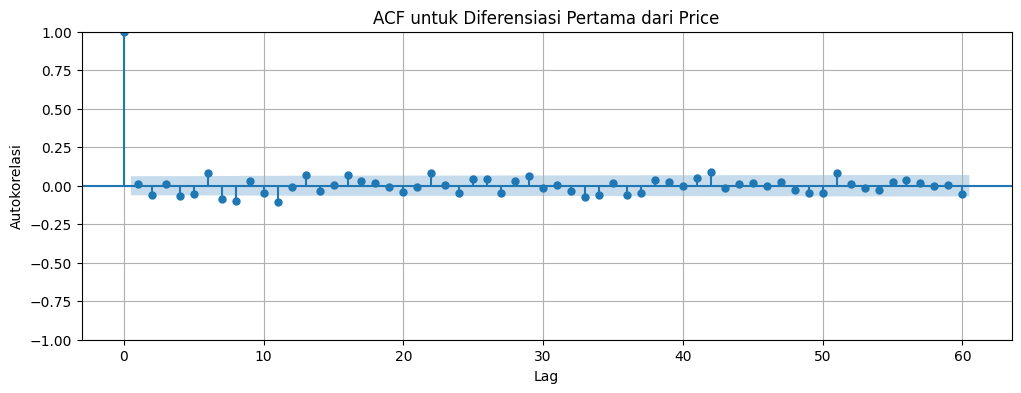

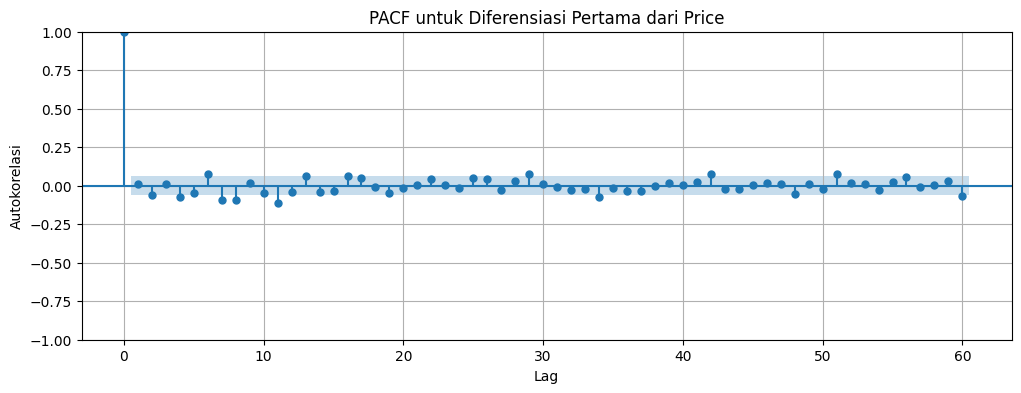

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
plt.figure(figsize=(12, 4))
plot_acf(df_diff, lags=60,ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Differenced Data')
plt.title(f'ACF untuk Diferensiasi Pertama dari Price')
plt.xlabel('Lag')
plt.ylabel('Autokorelasi')
plt.grid(True)
plt.show()

print()

# Plot PACF
plt.figure(figsize=(12, 4))
plot_pacf(df_diff, lags=60,ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Differenced Data')
plt.title(f'PACF untuk Diferensiasi Pertama dari Price')
plt.xlabel('Lag')
plt.ylabel('Autokorelasi')
plt.grid(True)
plt.show()
plt.show()


Sebelumnya kita sudah **Konfirmasi Non-Stasioneritas Melalui Uji ADF**

- Untuk mengkonfirmasi observasi visual, kita melakukan Uji Augmented Dickey-Fuller (ADF) pada deret waktu harga asli.
- Hasil uji ADF menunjukkan p-value sebesar **0.564115927289219**. Karena nilai ini **Lebih besar** dari tingkat signifikansi umum 0.05, kita **Gagal menolak** hipotesis nol.
- **Kesimpulan:** Uji ADF secara statistik mengkonfirmasi bahwa deret waktu harga Crude Oil WTI asli **kemungkinan non-stasioner**.

**Stasionerisasi yang Berhasil dengan Differencing**
- Sebagai respons terhadap non-stasioneritas, kita melakukan differencing orde pertama pada deret waktu harga.
- Uji ADF kembali dilakukan pada deret waktu yang telah didifferencing.
- Hasil uji ADF pada data yang didifferencing menunjukkan p-value sebesar **8.777759270918779e-23**. Karena nilai ini **Lebih kecil** dari 0.05, kita **Menolak** hipotesis nol.
- **Kesimpulan:** Deret waktu harga Crude Oil WTI setelah differencing orde pertama **kemungkinan stasioner**. Ini menetapkan orde differencing (d) untuk model SARIMA menjadi 1.

Berdasarkan plot ACF dan PACF di atas, kita dapat mengestimasi nilai awal untuk $p$ dan $q$. Karena ACF cut off setelah lag 1 dan PACF cut off setelah lag 1, maka ordo $(p,d,q)$ awal yang bisa dicoba adalah $(1,1,1)$.

Lalu, agak memaksakan. Tapi, sedikit terlihat adanya batang pada ACF dan PACF yang melewati batas pada titik-titik berikut $(6, 13, 22, 42, 51, ...)$.

Akan tetapi, pada lag-lag tersebut terlihat tidak menunjukkan adanya pengulangan. Berdasarkan analisis kita, jika plot ACF/PACF tidak menunjukkan pola berulang yang jelas pada kelipatan lag tertentu, maka kita dapat menyimpulkan secara statistik bahwa model ARIMA tanpa komponen musiman (seperti ARIMA $(1,1,2)$ pada section sebelumnya) mungkin sudah cukup memadai dan tidak perlu menambahkan komponen musiman.


Selanjutnya, kita akan lakukan transformasi untuk menstabilisasi varians

## Transformasi Data untuk Stabilisasi Varians

Seperti yang teridentifikasi dari diagnostik residual model ARIMA(1,1,2) sebelumnya:

1.  **Residual Tidak Normal:** Uji Jarque-Bera menunjukkan residual tidak berdistribusi normal.
2.  **Heteroskedastisitas:** Uji ARCH mengindikasikan adanya heteroskedastisitas (varians tidak konstan) pada residual.

Kedua kondisi ini dapat mempengaruhi validitas inferensi model dan akurasi peramalan. Transformasi data seringkali dapat membantu menstabilkan varians dan membuat distribusi data lebih mendekati normal, sehingga memenuhi asumsi model runtun waktu dengan lebih baik.

Beberapa transformasi umum untuk deret waktu antara lain:

*   **Transformasi Logaritmik (Log Transformation):** Sering digunakan untuk deret waktu yang menunjukkan pertumbuhan eksponensial atau ketika varians meningkat seiring dengan nilai deret waktu (heteroskedastisitas). Transformasi log dapat menstabilkan varians dan membuat distribusi lebih simetris.
*   **Transformasi Box-Cox:** Transformasi yang lebih umum yang mencakup transformasi log sebagai kasus khusus. Ini adalah keluarga transformasi yang diparameterisasi oleh $\lambda$, yang dapat membantu menstabilkan varians dan menormalkan distribusi data. Nilai optimal $\lambda$ biasanya ditentukan dari data.
*   **Akar Kuadrat (Square Root Transformation):** Kasus khusus dari Box-Cox ($\lambda=0.5$), cocok untuk data hitungan atau ketika varians sebanding dengan rata-rata.

Berdasarkan karakteristik data harga Crude Oil WTI yang menunjukkan volatilitas berkelompok (indikasi dari ARCH test), diputuskan akan menggunakan **Transformasi Logaritmik** sebagai pilihan yang umum dan sering efektif untuk menstabilkan varians.

Mari kita terapkan transformasi logaritmik pada kolom target (`price`) sebelum melakukan pemodelan lanjutan.


### Menerapkan Transformasi Logaritmik

In [ ]:
# Menerapkan transformasi logaritmik pada kolom target
df_transformed = df.copy()
# Karena harga minyak > 0, kita bisa langsung menggunakan log
df_transformed[target_column + '_log'] = np.log(df_transformed[target_column])

# Definisikan kolom target yang baru setelah transformasi
target_column_transformed = target_column + '_log'

print(f"Data asli ({target_column}) dan data setelah transformasi logaritmik ({target_column_transformed}):")
print(df_transformed.head())

Data asli (price) dan data setelah transformasi logaritmik (price_log):
            price   open   high    low     vol-k  change-%  price_log
date                                                                 
2022-01-03  75.85  75.53  76.18  74.01  112230.0      1.30   4.328758
2022-01-04  76.74  75.80  77.40  75.47  156450.0      1.17   4.340423
2022-01-05  77.47  76.88  78.16  76.25  197970.0      0.95   4.349891
2022-01-06  78.88  76.79  79.56  76.28  244000.0      1.82   4.367928
2022-01-07  78.44  79.00  79.82  78.07  229280.0     -0.56   4.362334


### Visualisasi Data Setelah Transformasi Logaritmik

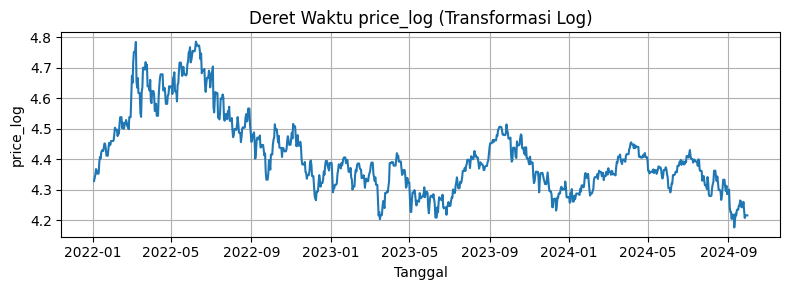

In [ ]:
# Visualisasikan deret waktu setelah transformasi logaritmik

plt.figure(figsize=(8, 3))
plt.plot(df_transformed.index, df_transformed[target_column_transformed])
plt.title(f'Deret Waktu {target_column_transformed} (Transformasi Log)')
plt.xlabel('Tanggal')
plt.ylabel(target_column_transformed)
plt.grid(True)
plt.tight_layout()
plt.show()

Visualisasi deret waktu setelah transformasi logaritmik menunjukkan bahwa fluktuasi dalam varians tampak lebih stabil dibandingkan dengan data asli. Ini adalah indikasi awal bahwa transformasi logaritmik mungkin efektif dalam mengatasi heteroskedastisitas.

### Uji Stasioneritas Setelah Transformasi Logaritmik

Kita perlu memastikan bahwa data yang ditransformasi juga stasioner, atau stasioner setelah didifferencing.


In [ ]:
# Melakukan Uji ADF pada data yang sudah ditransformasi log
print(f"Melakukan Uji ADF pada data {target_column_transformed}...\n")

adf_result_log = adfuller(df_transformed[target_column_transformed])
print(f'ADF Statistic (Transformasi Log): {adf_result_log[0]:.4f}')
print(f'p-value (Transformasi Log): {adf_result_log[1]:.10f}')

print("\nInterpretasi Uji ADF pada data yang ditransformasi Log:")
if adf_result_log[1] <= 0.05:
    print("✅ Uji ADF menolak hipotesis nol (p-value <= 0.05). Deret waktu kemungkinan stasioner.")
else:
    print("❌ Uji ADF gagal menolak hipotesis nol (p-value > 0.05). Deret waktu kemungkinan non-stasioner.")
    print("Differencing mungkin masih diperlukan pada data yang ditransformasi.")


Melakukan Uji ADF pada data price_log...

ADF Statistic (Transformasi Log): -1.3757
p-value (Transformasi Log): 0.5938768194

Interpretasi Uji ADF pada data yang ditransformasi Log:
❌ Uji ADF gagal menolak hipotesis nol (p-value > 0.05). Deret waktu kemungkinan non-stasioner.
Differencing mungkin masih diperlukan pada data yang ditransformasi.


Berdasarkan hasil Uji ADF pada data yang ditransformasi logaritmik, p-value masih tinggi $(0.5938768194)$, menunjukkan bahwa data ini masih non-stasioner.

Kita perlu melakukan differencing lagi untuk mencapai stasioneritas. Ini konsisten dengan temuan pada data asli, di mana differencing orde pertama diperlukan.


### Melakukan Differencing Orde Pertama pada Data yang Ditransformasi Log


In [ ]:
# Membuat deret waktu yang sudah ditransformasi log dan didifferencing orde pertama
df_transformed_diff = df_transformed[target_column_transformed].diff().dropna()

### Uji Stasioneritas Setelah Transformasi Log dan Differencing


In [ ]:
# Melakukan Uji ADF pada data yang sudah ditransformasi log dan didifferencing
print(f"Melakukan Uji ADF pada data {target_column_transformed} setelah differencing...\n")

adf_result_log_diff = adfuller(df_transformed_diff)
print(f'ADF Statistic (Transformasi Log & Differencing): {adf_result_log_diff[0]:.4f}')
print(f'p-value (Transformasi Log & Differencing): {adf_result_log_diff[1]:.10f}')

print("\nInterpretasi Uji ADF pada data yang ditransformasi Log dan Didifferencing:")
if adf_result_log_diff[1] <= 0.05:
    print("✅ Uji ADF menolak hipotesis nol (p-value <= 0.05). Deret waktu kemungkinan stasioner.")
else:
    print("❌ Uji ADF gagal menolak hipotesis nol (p-value > 0.05). Deret waktu kemungkinan non-stasioner.")
    print("Differencing lebih lanjut mungkin diperlukan.")

Melakukan Uji ADF pada data price_log setelah differencing...

ADF Statistic (Transformasi Log & Differencing): -9.2771
p-value (Transformasi Log & Differencing): 0.0000000000

Interpretasi Uji ADF pada data yang ditransformasi Log dan Didifferencing:
✅ Uji ADF menolak hipotesis nol (p-value <= 0.05). Deret waktu kemungkinan stasioner.


Hasil Uji ADF setelah transformasi logaritmik dan differencing orde pertama menunjukkan p-value yang sangat kecil $(0)$, yang menolak hipotesis nol dan mengkonfirmasi bahwa deret waktu ini sekarang stasioner. Ini berarti kita dapat melanjutkan pemodelan ARIMA atau SARIMA pada data yang telah ditransformasi logaritmik dan didifferencing.


### Analisis ACF dan PACF pada Data yang Ditransformasi Log dan Didifferencing

Sekarang kita akan melihat plot ACF dan PACF dari data yang telah ditransformasi logaritmik dan didifferencing. Plot ini akan membantu kita dalam menentukan ordo (p, q) untuk model ARIMA atau (p, q) dan (P, Q, S) untuk model SARIMA pada data yang sudah distabilkan variansnya.


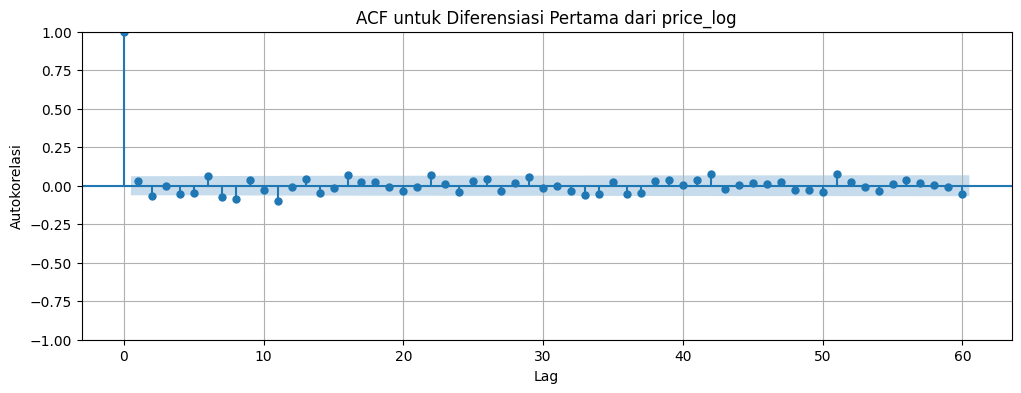

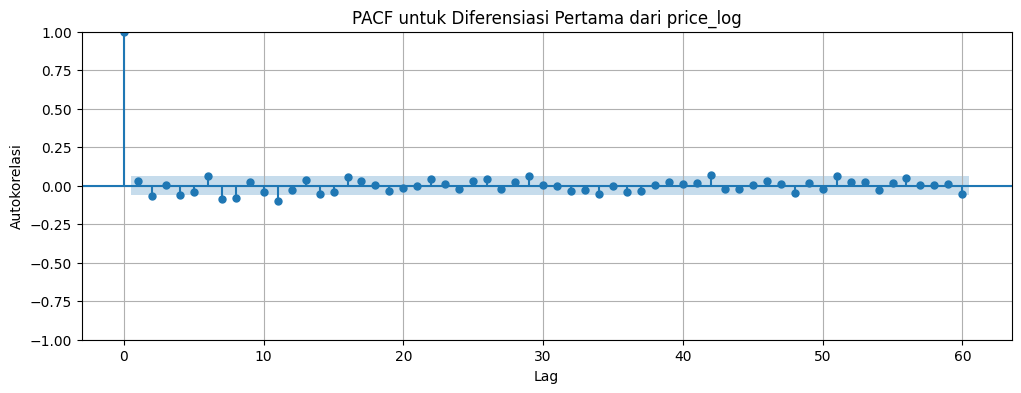

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
plt.figure(figsize=(12, 4))
plot_acf(df_transformed_diff, lags=60, ax=plt.gca())
plt.title(f'ACF untuk Diferensiasi Pertama dari {target_column_transformed}')
plt.xlabel('Lag')
plt.ylabel('Autokorelasi')
plt.grid(True)
plt.show()

print()

# Plot PACF
plt.figure(figsize=(12, 4))
plot_pacf(df_transformed_diff, lags=60, ax=plt.gca())
plt.title(f'PACF untuk Diferensiasi Pertama dari {target_column_transformed}')
plt.xlabel('Lag')
plt.ylabel('Autokorelasi')
plt.grid(True)
plt.show()


Berdasarkan plot ACF dan PACF pada data yang telah ditransformasi logaritmik dan didifferencing plot ACF dan PACF di atas, kita dapat mengestimasi nilai awal untuk $p$ dan $q$. Karena ACF cut off setelah lag 1 dan PACF cut off setelah lag 1, maka ordo $(p,d,q)$ awal yang bisa dicoba adalah $(1,1,1)$. Serupa dengan sebelum transformasi.

Lalu, agak memaksakan serupa juga dengan sebelum transformasi. Tapi, sedikit terlihat adanya batang pada ACF dan PACF yang melewati batas pada titik-titik berikut $(6, 42, 51, ...)$.

Akan tetapi, pada lag-lag tersebut terlihat tidak menunjukkan adanya pengulangan.

Berdasarkan analisis kita, jika plot ACF/PACF tidak menunjukkan pola berulang yang jelas pada kelipatan lag tertentu, maka kita dapat menyimpulkan secara statistik bahwa model meskipun dengan transformasi model ARIMA tanpa komponen musiman (seperti ARIMA mungkin $(1,1,1)$ atau $(1,1,2)$ pada section sebelumnya) mungkin sudah cukup memadai dan tidak perlu menambahkan komponen musiman.


## Pemodelan Volatilitas dengan ARCH/GARCH

Sebelumnya, diagnostik residual model ARIMA(1,1,2) secara statistik mengkonfirmasi adanya **heteroskedastisitas** (varians yang tidak konstan). Fenomena ini, sering disebut sebagai volatilitas berkelompok (volatility clustering), umum terjadi pada deret waktu keuangan. Ini berarti bahwa periode volatilitas tinggi cenderung diikuti oleh periode volatilitas tinggi, dan periode volatilitas rendah diikuti oleh periode volatilitas rendah.

Model **ARCH (Autoregressive Conditional Heteroskedasticity)** dan **GARCH (Generalized Autoregressive Conditional Heteroskedasticity)** dirancang khusus untuk memodelkan dan memperkirakan varians (volatilitas) deret waktu yang bervariasi seiring waktu.

*   **Model ARCH(q):** Memodelkan varians kondisional pada periode $t$ ($\sigma_t^2$) sebagai fungsi linear dari kuadrat residual dari $q$ periode sebelumnya ($\epsilon_{t-1}^2, \epsilon_{t-2}^2, ..., \epsilon_{t-q}^2$).
$$ \sigma_t^2 = \omega + \alpha_1 \epsilon_{t-1}^2 + \alpha_2 \epsilon_{t-2}^2 + ... + \alpha_q \epsilon_{t-q}^2
$$
*   **Model GARCH(p, q):** Merupakan generalisasi dari ARCH, yang memodelkan varians kondisional tidak hanya berdasarkan kuadrat residual masa lalu, tetapi juga berdasarkan varians kondisional masa lalu ($\sigma_{t-1}^2, \sigma_{t-2}^2, ..., \sigma_{t-p}^2$). Ini seringkali lebih efektif dalam menangkap dinamika volatilitas yang persisten. [1]
$$
\sigma_t^2 = \omega + \sum_{i=1}^q \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2
$$

Di sini, kita akan menerapkan model GARCH pada residual dari model mean (dalam kasus ini, residual dari model ARIMA(1,1,2) yang telah kita latih sebelumnya). Langkah-langkahnya adalah sebagai berikut:

1.  Mengekstrak residual dari model mean yang sudah dilatih.
2.  Melatih model ARCH atau GARCH pada residual tersebut.
3.  Mengevaluasi model ARCH/GARCH.
4.  Menggunakan model gabungan (model mean + model volatilitas) untuk peramalan


### Import Package untuk Pemodelan Volatilitas

In [ ]:
# Install package arch jika belum terinstall
%pip install arch

In [ ]:
# Import package
import pickle
import os

# Import model ARCH
from arch import arch_model

### Persiapkan Model ARIMA(1,1,2)

#### Bagi Data Latih dan Data Uji (Time Series Split)


**Menggunakan Metode Fixed Split:**

Sama seperti notebook sebelumnya, kita akan menggunakan metode _fixed split_ untuk demonstrasi ini, membagi data menjadi data latih (sebelum tanggal 1 Januari 2024) dan data uji (tanggal 1 januari 2024 sampai akhir data ini yakni 30 September 2024).

Pada makna bisnis yang disimulasikan seperti client ingin mengetahui harga `minyak mentah` pada tahun 2024. Dari informasi data yakni dari 2022 sampai 2023.


In [ ]:
# Tentukan tanggal atau indeks untuk membagi data
split_date = '2024-01-01'

# Pembagian data berdasarkan indeks
data_latih = df.iloc[df.index < split_date].copy()
data_uji = df.iloc[df.index >= split_date].copy()

print(f"Dataset asli memiliki {len(df)} baris.")
print(f"Data latih: {len(data_latih)} baris (hingga {data_latih.index[-1] if not data_latih.empty else 'kosong'}).")
print(f"Data uji: {len(data_uji)} baris (dari {data_uji.index[0] if not data_uji.empty else 'kosong'} hingga {data_uji.index[-1] if not data_uji.empty else 'kosong'}).")


Dataset asli memiliki 1002 baris.
Data latih: 728 baris (hingga 2023-12-31 00:00:00).
Data uji: 274 baris (dari 2024-01-01 00:00:00 hingga 2024-09-30 00:00:00).


Visualisasi

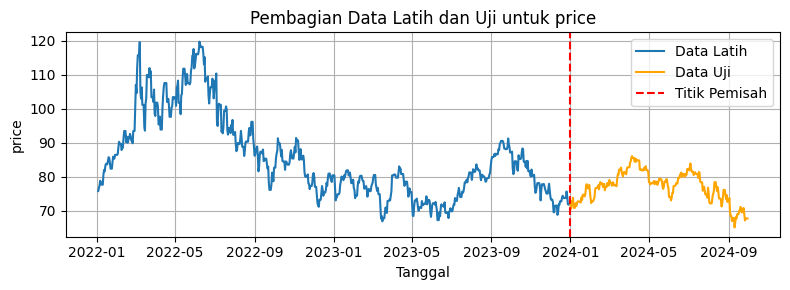

In [ ]:
# Visualisasikan pembagian data
plt.figure(figsize=(8, 3))
plt.plot(data_latih.index, data_latih[target_column], label='Data Latih')
plt.plot(data_uji.index, data_uji[target_column], label='Data Uji', color='orange')
plt.axvline(pd.to_datetime(split_date), color='red', linestyle='--', label='Titik Pemisah')
plt.title(f'Pembagian Data Latih dan Uji untuk {target_column}')
plt.xlabel('Tanggal')
plt.ylabel(target_column)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pickle
import requests
import os

# Definisikan path lokal tempat model seharusnya berada
direktori_model_lokal = 'outputs/model/'
file_model_arima = 'arima_crude_oil_model.pkl'
path_model_lokal = os.path.join(direktori_model_lokal, file_model_arima)

# URL raw content file pickle di GitHub
url_model_arima = 'https://raw.githubusercontent.com/zakizulham/proyek-peramalan-global-comodity-price-september-2024/main/outputs/model/arima_crude_oil_model.pkl'

# Periksa apakah file model ada di path lokal
if os.path.exists(path_model_lokal):
    print(f"File model ditemukan di '{path_model_lokal}'. Memuat dari lokal...")
    try:
        # Memuat model dari file pickle lokal
        with open(path_model_lokal, 'rb') as f:
            model_fit1 = pickle.load(f)

        print(f"Model ARIMA berhasil dimuat dari '{path_model_lokal}'.")
        print("\nRingkasan Model yang Dimuat:")
        print(model_fit1.summary())

    except Exception as e:
        print(f"Gagal memuat model dari file lokal '{path_model_lokal}': {e}")

else:
    print(f"File model tidak ditemukan di '{path_model_lokal}'. Mengunduh dari GitHub...")
    # Pastikan direktori lokal ada sebelum menyimpan file
    os.makedirs(direktori_model_lokal, exist_ok=True)

    try:
        response = requests.get(url_model_arima)
        response.raise_for_status()

        # Simpan file yang diunduh secara lokal di Colab
        with open(path_model_lokal, 'wb') as f:
            f.write(response.content)

        print(f"File model berhasil diunduh dan disimpan sebagai '{path_model_lokal}'.")

        # Memuat model dari file pickle yang baru diunduh
        with open(path_model_lokal, 'rb') as f:
            model_fit1 = pickle.load(f)

        print(f"Model ARIMA berhasil dimuat dari '{path_model_lokal}'.")
        print("\nRingkasan Model yang Dimuat:")
        print(model_fit1.summary())

    except requests.exceptions.RequestException as e:
        print(f"Gagal mengunduh file model dari GitHub: {e}")
    except Exception as e:
        print(f"Gagal memuat model dari file yang baru diunduh '{path_model_lokal}': {e}")

File model ditemukan di 'outputs/model/arima_crude_oil_model.pkl'. Memuat dari lokal...
Model ARIMA berhasil dimuat dari 'outputs/model/arima_crude_oil_model.pkl'.

Ringkasan Model yang Dimuat:
                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  728
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -1533.379
Date:                Wed, 11 Jun 2025   AIC                           3074.758
Time:                        10:58:46   BIC                           3093.113
Sample:                    01-03-2022   HQIC                          3081.841
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0

### Mengekstrak Residual dari Model Mean

Kita akan menggunakan residual dari model ARIMA(1,1,2) yang dilatih pada data latih sebelumnya (`model_fit1.resid`). Residual ini mewakili bagian dari deret waktu yang tidak dijelaskan oleh komponen rata-rata model ARIMA.


In [ ]:
# Residual dari model ARIMA(1,1,2)
residuals_arima = model_fit1.resid

print("Residual dari model ARIMA(1,1,2):")
print(residuals_arima.head())
print(f"\nJumlah residual: {len(residuals_arima)}")

Residual dari model ARIMA(1,1,2):
date
2022-01-03    75.850000
2022-01-04     0.889994
2022-01-05     0.713278
2022-01-06     1.448202
2022-01-07    -0.381139
Freq: D, dtype: float64

Jumlah residual: 728


### Melatih Model GARCH pada Residual

Model GARCH(1,1) adalah model yang paling umum dan seringkali memberikan hasil yang baik. Ini memodelkan varians saat ini sebagai fungsi dari kuadrat residual periode sebelumnya (efek ARCH) dan varians kondisional periode sebelumnya (efek GARCH).

Kita akan menggunakan `arch_model` dari pustaka `arch`. Argumen `y` adalah deret waktu yang ingin dimodelkan volatilitasnya (dalam kasus ini, residual). Argumen `vol='Garch'` menentukan penggunaan model GARCH. Ordo ARCH (q) dan GARCH (p) ditentukan oleh `p` dan `q` dalam `arch_model(..., p=p, q=q)`. Untuk GARCH(1,1), kita gunakan `p=1, q=1`.

Karena kita memodelkan residual dari model ARIMA, yang seharusnya sudah mendekati rata-rata nol, kita bisa menggunakan `mean='Zero'`. Jika kita memodelkan deret waktu asli langsung, kita mungkin ingin menggunakan `mean='Constant'` atau model mean lainnya.

In [ ]:
# Definisikan ordo GARCH (p, q)
garch_p = 1
garch_q = 1

# Buat model GARCH(1,1) pada residual ARIMA
# Gunakan mean='Zero' karena kita memodelkan residual yang rata-ratanya mendekati nol
model_garch = arch_model(residuals_arima, mean='Zero', vol='Garch', p=garch_p, q=garch_q)

# Latih model GARCH
# Gunakan update_freq=0 untuk menekan output saat pelatihan (opsional)
model_garch_fit = model_garch.fit(disp='off')

# Tampilkan ringkasan model GARCH
print(model_garch_fit.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1504.12
Distribution:                  Normal   AIC:                           3014.24
Method:            Maximum Likelihood   BIC:                           3028.01
                                        No. Observations:                  728
Date:                Wed, Jun 11 2025   Df Residuals:                      728
Time:                        10:58:46   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.3092      0.128      2.420  1.552e-02 [5.876e-0

Dari hasil model **Zero Mean-GARCH** dengan distribusi normal, kita dapat mengambil insight berikut:

### Signifikansi Parameter Volatilitas  
- **omega** (tingkat volatilitas dasar):  
  - Signifikan secara statistik (`P>|t| = 0.015 < 0.05`)  
  - Interval kepercayaan 95%: `[0.059, 0.560]` (tidak mencakup nol)  
- **alpha[1]** (pengaruh guncangan/error periode sebelumnya):  
  - Sangat signifikan (`P>|t| = 0.0002 < 0.05`)  
  - Koefisien `0.1685` menunjukkan guncangan masa lalu memengaruhi volatilitas saat ini  
- **beta[1]** (persistensi volatilitas):  
  - Sangat signifikan (`P>|t| ≈ 0 < 0.05`)  
  - Koefisien tinggi (`0.7573`) mengindikasikan volatilitas bersifat *persisten*  

### Implikasi Parameter  
- **Total pengaruh volatilitas** (`alpha[1] + beta[1] = 0.9258`):  
  - Mendekati 1 → volatilitas cenderung bertahan lama (*high persistence*)  
  - Konsisten dengan karakteristik data finansial yang memiliki *volatility clustering*  



Ljung-Box Test on Standardized Residuals Squared:
      lb_stat  lb_pvalue
1    0.373996   0.540834
2    3.347398   0.187552
3    3.445669   0.327877
4    4.631642   0.327222
5    4.647302   0.460420
6    4.682642   0.585112
7   16.260878   0.022837
8   17.761859   0.023084
9   17.980077   0.035405
10  19.966033   0.029576
11  20.102670   0.043952
12  22.228183   0.035041
13  24.063271   0.030553
14  25.171697   0.032910
15  25.417953   0.044604
16  26.387735   0.048811
17  26.785861   0.061284
18  37.808086   0.004106
19  38.823311   0.004655
20  39.154027   0.006379
21  39.773632   0.007922
22  42.633410   0.005234
23  46.066462   0.002935
24  46.066539   0.004346
25  50.157040   0.002038
26  51.323560   0.002178
27  51.439987   0.003090
28  52.944935   0.002980
29  53.733789   0.003471
30  55.007713   0.003543
31  55.162190   0.004802
32  55.977185   0.005457
33  57.406105   0.005308
34  59.260871   0.004649
35  63.515238   0.002237
36  63.582261   0.003071
37  64.153533   0.003687

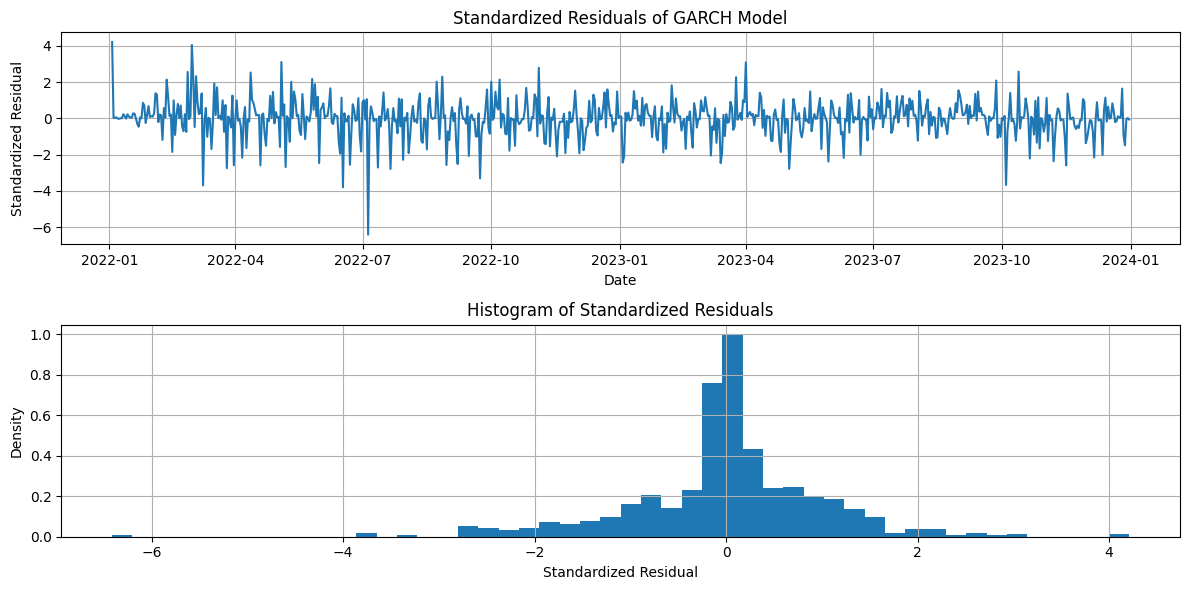

In [ ]:
# Akses residual standar dari model GARCH
std_residuals = model_garch_fit.std_resid

# 1. Uji Ljung-Box pada Residual Standar Kuadrat
# Ini untuk memeriksa sisa efek ARCH/autokorelasi pada volatilitas
# Jika p-value tinggi (>= 0.05), model GARCH berhasil menangkap sebagian besar heteroskedastisitas
ljungbox_results = acorr_ljungbox(std_residuals**2, lags=40, return_df=True)
print("\nLjung-Box Test on Standardized Residuals Squared:")
print(ljungbox_results)
# Perhatikan kolom 'lb_pvalue'. Jika semua p-value tinggi, itu bagus.

# 2. Uji Jarque-Bera pada Residual Standar
# Ini untuk memeriksa normalitas residual standar
# Jika p-value tinggi (>= 0.05), residual mendekati distribusi normal
jarque_bera_statistic, jarque_bera_pvalue = norm.fit(std_residuals)[0], norm.fit(std_residuals)[1] # Ini cara mengambil dari stats.norm.fit, kurang standar
# Cara yang lebih standar menggunakan statsmodels:
from statsmodels.stats.stattools import jarque_bera
jb_test = jarque_bera(std_residuals)
jarque_bera_statistic = jb_test[0]
jarque_bera_pvalue = jb_test[1]

print(f"\nJarque-Bera Test on Standardized Residuals:")
print(f"Statistic: {jarque_bera_statistic:.4f}")
print(f"p-value: {jarque_bera_pvalue:.4f}")

# 3. Visualisasi Residual Standar
# Plot residual standar dan histogramnya
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(std_residuals.index, std_residuals)
plt.title('Standardized Residuals of GARCH Model')
plt.xlabel('Date')
plt.ylabel('Standardized Residual')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.hist(std_residuals, bins=50, density=True)
plt.title('Histogram of Standardized Residuals')
plt.xlabel('Standardized Residual')
plt.ylabel('Density')
plt.grid(True)

plt.tight_layout()
plt.show()

Berdasarkan hasil diagnostik residual model GARCH, berikut temuan yang dapat diambil:

#### **1. Uji Ljung-Box pada Residual Kuadrat Standar**  
- **Lag rendah (1-6)**: Tidak terdeteksi autokorelasi signifikan (*p-value* ≥ 0.18), menunjukkan model berhasil menangkap heteroskedastisitas jangka pendek.  
- **Lag menengah-tinggi (7-20)**: Terdapat autokorelasi sangat signifikan (*p-value* ≤ 0.04 pada lag ≥7), mengindikasikan **sisa efek ARCH yang tidak termodelkan** terutama pada volatilitas jangka panjang.  

#### **2. Uji Jarque-Bera pada Residual Standar**  
- **Statistik uji**: 495.12 (*p-value* = 0.000)  
- **Implikasi**: Residual **tidak berdistribusi normal**, menunjukkan karakteristik *fat tails* (ekor gemuk) yang umum pada data finansial.  

#### **3. Keterbatasan Model dan Rekomendasi**  
- **Keterbatasan**:  
  - Model gagal menangkap heteroskedastisitas pada lag tinggi.  
  - Asumsi normalitas residual tidak terpenuhi.  
- **Rekomendasi Perbaikan**:  
  - Tingkatkan spesifikasi model (misal: GARCH(2,1) atau EGARCH) untuk menangkap persistensi lag tinggi.  
  - Ganti distribusi error dari normal ke *t-student* atau *skewed t-student* untuk mengakomodasi *fat tails*.  
  - Validasi dengan membandingkan kriteria AIC/BIC terhadap model alternatif.  

### **Kesimpulan Utama**  
Model saat ini memadai untuk volatilitas jangka pendek tetapi **memerlukan penyempurnaan** untuk menangkap dinamika jangka panjang dan distribusi ekor gemuk. Perbaikan spesifikasi diharapkan meningkatkan akurasi peramalan volatilitas.

Residual dari model ARIMA(1,1,2):
date
2022-01-03    75.850000
2022-01-04     0.889994
2022-01-05     0.713278
2022-01-06     1.448202
2022-01-07    -0.381139
Freq: D, Name: None, dtype: float64

Jumlah residual: 728

--- Melatih Model GARCH(1,1) dengan Distribusi t ---

Ringkasan Model GARCH(1,1) dengan Distribusi t:
                          Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.001
Vol Model:                            GARCH   Log-Likelihood:               -1424.95
Distribution:      Standardized Student's t   AIC:                           2857.91
Method:                  Maximum Likelihood   BIC:                           2876.27
                                              No. Observations:                  728
Date:                      Wed, Jun 11 2025   Df Residuals:                      728


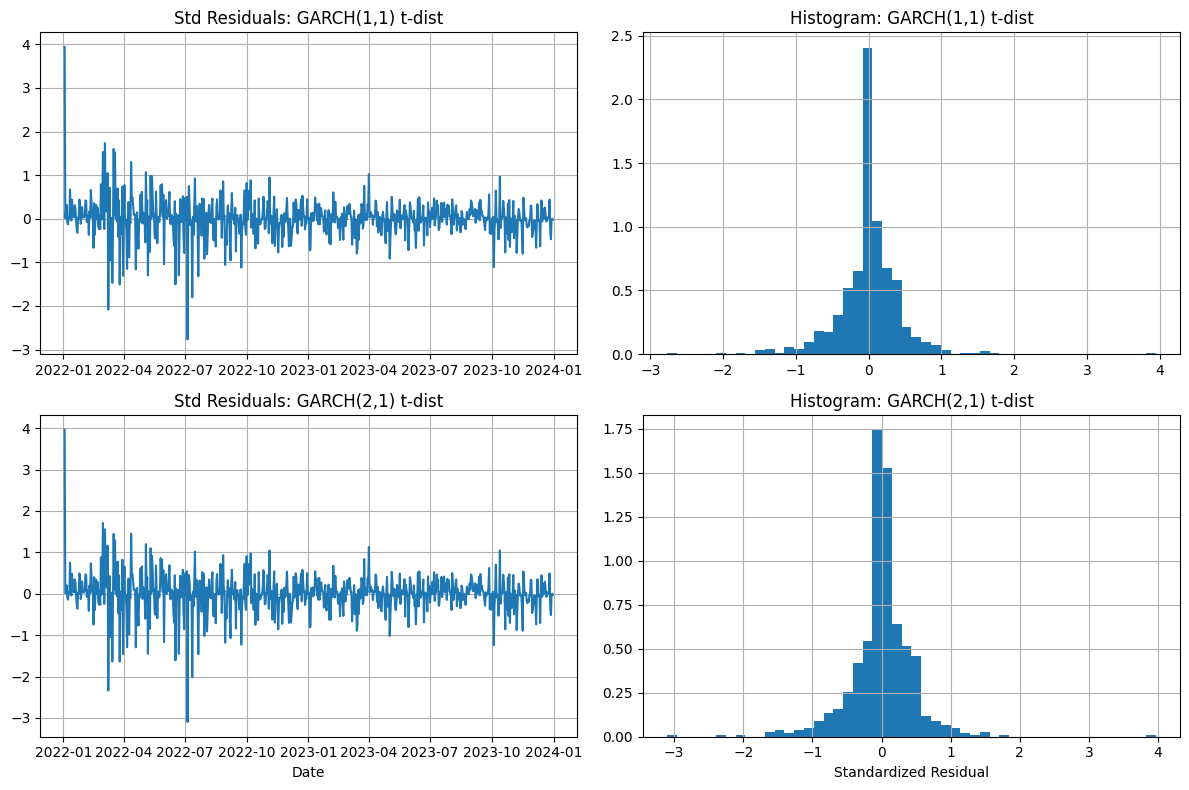

In [ ]:
# Import package yang diperlukan
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Pastikan pandas diimport jika diperlukan
from scipy.stats import norm # Masih diperlukan untuk Uji Jarque-Bera manual jika tidak pakai statsmodels

# Asumsikan residuals_arima sudah ada dan berisi residual dari model ARIMA Anda
# Jika belum, pastikan residuals_arima sudah terdefinisi
# residuals_arima = model_fit1.resid # Contoh jika Anda butuh mendefinisikannya lagi

print("Residual dari model ARIMA(1,1,2):")
print(residuals_arima.head())
print(f"\nJumlah residual: {len(residuals_arima)}")


# --- Coba Model 1: GARCH(1,1) dengan Distribusi t-Student ---
print("\n--- Melatih Model GARCH(1,1) dengan Distribusi t ---")

# Definisikan ordo GARCH (p, q)
garch_p_t1 = 1
garch_q_t1 = 1

# Buat model GARCH(1,1) pada residual ARIMA, mean='Zero', dan distribusi error='t'
model_garch_t1 = arch_model(residuals_arima, mean='Zero', vol='Garch', p=garch_p_t1, q=garch_q_t1, dist='t')

# Latih model
model_garch_t1_fit = model_garch_t1.fit(disp='off')

# Tampilkan ringkasan model
print("\nRingkasan Model GARCH(1,1) dengan Distribusi t:")
print(model_garch_t1_fit.summary())

# Diagnostik Residual untuk Model GARCH(1,1) dengan Distribusi t
std_residuals_t1 = model_garch_t1_fit.std_resid

print("\nDiagnostik Residual untuk Model GARCH(1,1) dengan Distribusi t:")
# Uji Ljung-Box pada Residual Standar Kuadrat
ljungbox_results_t1 = acorr_ljungbox(std_residuals_t1**2, lags=40, return_df=True)
print("Ljung-Box Test on Standardized Residuals Squared:")
print(ljungbox_results_t1.head()) # Tampilkan beberapa baris pertama saja
# Anda perlu memeriksa p-value pada semua lag

# Uji Jarque-Bera pada Residual Standar
jb_test_t1 = jarque_bera(std_residuals_t1)
print(f"\nJarque-Bera Test on Standardized Residuals:")
print(f"Statistic: {jb_test_t1[0]:.4f}, p-value: {jb_test_t1[1]:.4f}")


# --- Coba Model 2: GARCH(2,1) dengan Distribusi t-Student ---
print("\n--- Melatih Model GARCH(2,1) dengan Distribusi t ---")

# Definisikan ordo GARCH (p, q)
garch_p_t2 = 2 # Tingkatkan ordo AR GARCH
garch_q_t2 = 1

# Buat model GARCH(2,1) pada residual ARIMA, mean='Zero', dan distribusi error='t'
model_garch_t2 = arch_model(residuals_arima, mean='Zero', vol='Garch', p=garch_p_t2, q=garch_q_t2, dist='t')

# Latih model
model_garch_t2_fit = model_garch_t2.fit(disp='off')

# Tampilkan ringkasan model
print("\nRingkasan Model GARCH(2,1) dengan Distribusi t:")
print(model_garch_t2_fit.summary())

# Diagnostik Residual untuk Model GARCH(2,1) dengan Distribusi t
std_residuals_t2 = model_garch_t2_fit.std_resid

print("\nDiagnostik Residual untuk Model GARCH(2,1) dengan Distribusi t:")
# Uji Ljung-Box pada Residual Standar Kuadrat
ljungbox_results_t2 = acorr_ljungbox(std_residuals_t2**2, lags=40, return_df=True)
print("Ljung-Box Test on Standardized Residuals Squared:")
print(ljungbox_results_t2.head()) # Tampilkan beberapa baris pertama saja
# Anda perlu memeriksa p-value pada semua lag

# Uji Jarque-Bera pada Residual Standar
jb_test_t2 = jarque_bera(std_residuals_t2)
print(f"\nJarque-Bera Test on Standardized Residuals:")
print(f"Statistic: {jb_test_t2[0]:.4f}, p-value: {jb_test_t2[1]:.4f}")


# --- Bandingkan Hasilnya ---
print("\n--- Perbandingan Hasil Model ---")
print("Periksa ringkasan model (AIC/BIC) dan hasil diagnostik residual (Ljung-Box p-value pada residual kuadrat standar, Jarque-Bera p-value pada residual standar).")
print("Model yang lebih baik akan memiliki:")
print("- AIC/BIC yang lebih rendah")
print("- P-value Ljung-Box yang lebih tinggi (idealnya >= 0.05) pada lebih banyak lag untuk residual standar kuadrat.")
print("- (Opsional) P-value Jarque-Bera yang lebih tinggi, meskipun residual finansial seringkali tetap tidak normal sempurna.")

# Visualisasikan Residual Standar dari kedua model untuk perbandingan visual
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(std_residuals_t1.index, std_residuals_t1)
plt.title('Std Residuals: GARCH(1,1) t-dist')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.hist(std_residuals_t1, bins=50, density=True)
plt.title('Histogram: GARCH(1,1) t-dist')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(std_residuals_t2.index, std_residuals_t2)
plt.title('Std Residuals: GARCH(2,1) t-dist')
plt.xlabel('Date')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.hist(std_residuals_t2, bins=50, density=True)
plt.title('Histogram: GARCH(2,1) t-dist')
plt.xlabel('Standardized Residual')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Import package yang diperlukan
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm # Masih diperlukan untuk Uji Jarque-Bera manual jika tidak pakai statsmodels

# --- Asumsikan residuals_arima sudah ada ---
# Ini adalah residual dari SALAH SATU model ARIMA Anda, misalnya ARIMA(1,1,2)
# Pastikan residuals_arima sudah terdefinisi sebelum menjalankan kode ini.
# Contoh: residuals_arima = model_fit1.resid
print("Residual dari model ARIMA (untuk pemodelan GARCH):")
print(residuals_arima.head())
print(f"\nJumlah residual: {len(residuals_arima)}")


# --- Definisikan Kombinasi Ordo GARCH yang Ingin Dicoba ---
garch_orders_to_try = [(1, 1), (2, 1), (1, 2), (2,2)] # Tambahkan kombinasi lain di sini

# --- List untuk menyimpan hasil model dan diagnostik ---
garch_models_results = {}


# --- Latih dan Evaluasi Model GARCH untuk Setiap Ordo ---
print("\n--- Melatih dan Mengevaluasi Model GARCH dengan Distribusi t ---")

for p, q in garch_orders_to_try:
    model_name = f'GARCH({p},{q})_tdist'
    print(f"\n--- Melatih Model {model_name} ---")

    try:
        # Buat model GARCH dengan mean='Zero' dan distribusi 't'
        # Anda bisa ganti mean='Zero' ke 'Constant' atau 'ARMA' jika perlu
        model_garch = arch_model(residuals_arima, mean='Zero', vol='Garch', p=p, q=q, dist='t')

        # Latih model
        model_garch_fit = model_garch.fit(disp='off')

        print(f"Ringkasan Model {model_name}:")
        print(model_garch_fit.summary())

        # Diagnostik Residual
        std_residuals = model_garch_fit.std_resid

        # Uji Ljung-Box pada Residual Standar Kuadrat
        ljungbox_results = acorr_ljungbox(std_residuals**2, lags=min(40, len(std_residuals)//2 - 1), return_df=True) # Sesuaikan lags
        print(f"\nLjung-Box Test on Standardized Residuals Squared ({model_name}):")
        print(ljungbox_results.head())

        # Uji Jarque-Bera pada Residual Standar
        jb_test = jarque_bera(std_residuals)
        print(f"Jarque-Bera Test on Standardized Residuals ({model_name}):")
        print(f"Statistic: {jb_test[0]:.4f}, p-value: {jb_test[1]:.4f}")

        # Simpan hasil penting
        garch_models_results[model_name] = {
            'summary': model_garch_fit.summary(),
            'aic': model_garch_fit.aic,
            'bic': model_garch_fit.bic,
            'ljungbox_sq_pvalues': ljungbox_results['lb_pvalue'].tolist(), # Simpan p-value
            'jarque_bera_pvalue': jb_test[1],
            'std_residuals': std_residuals # Mungkin perlu untuk visualisasi nanti
        }

    except Exception as e:
        print(f"Gagal melatih model {model_name}: {e}")
        garch_models_results[model_name] = {'error': str(e)}


# --- Perbandingan Hasil Akhir Model GARCH ---
print("\n--- Ringkasan Perbandingan Model GARCH ---")

comparison_df_garch = pd.DataFrame({
    name: {
        'AIC': res.get('aic'),
        'BIC': res.get('bic'),
        'JB_pvalue': res.get('jarque_bera_pvalue'),
        'LjungBox_Sq_SigLags': sum(p <= 0.05 for p in res.get('ljungbox_sq_pvalues', []) if p is not None) if 'error' not in res else None,
        'Error': res.get('error', 'None')
    } for name, res in garch_models_results.items()
}).T

print(comparison_df_garch)

# Visualisasikan Residual Standar (Opsional, bisa terlalu banyak plot jika banyak model)
# Jika Anda ingin memvisualisasikan, sebaiknya pilih beberapa model terbaik saja atau visualisasikan per model di loop pelatihan

# --- Interpretasi Hasil ---
print("\n--- Interpretasi ---")
print("Pilih model GARCH yang:")
print("- Memiliki AIC dan BIC paling rendah.")
print("- Memiliki jumlah lag signifikan (p-value <= 0.05) paling sedikit pada Uji Ljung-Box untuk residual standar kuadrat.")
print("- (Opsional) Memiliki p-value Jarque-Bera tertinggi, meskipun ini seringkali tetap rendah pada data finansial.")

Residual dari model ARIMA (untuk pemodelan GARCH):
date
2022-01-03    75.850000
2022-01-04     0.889994
2022-01-05     0.713278
2022-01-06     1.448202
2022-01-07    -0.381139
Freq: D, Name: None, dtype: float64

Jumlah residual: 728

--- Melatih dan Mengevaluasi Model GARCH dengan Distribusi t ---

--- Melatih Model GARCH(1,1)_tdist ---
Ringkasan Model GARCH(1,1)_tdist:
                          Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.001
Vol Model:                            GARCH   Log-Likelihood:               -1424.95
Distribution:      Standardized Student's t   AIC:                           2857.91
Method:                  Maximum Likelihood   BIC:                           2876.27
                                              No. Observations:                  728
Date:                      Wed,

#### Interpretasi Model GARCH dengan Distribusi Student's t  
Berdasarkan hasil pelatihan dan evaluasi empat model GARCH, berikut rangkuman profesional temuan kunci:

---

#### **1. Kinerja Model Berdasarkan Kriteria Seleksi**  
- **AIC & BIC Terendah**:  
  - **GARCH(1,1)_tdist** mencatat AIC (2857.91) dan BIC (2876.27) terendah, mengindikasikan efisiensi tertinggi dalam menyeimbangkan akurasi dan kompleksitas model.  
  - Model lain (GARCH(2,1), GARCH(1,2), GARCH(2,2)) memiliki nilai AIC/BIC lebih tinggi (+1.1 hingga +3.6), menunjukkan *overfitting* tanpa peningkatan signifikan.  

- **Uji Ljung-Box pada Residual Kuadrat**:  
  - **GARCH(1,1)_tdist** dan **GARCH(1,2)_tdist** menunjukkan *p-value* >0.05 untuk semua lag (1-5), membuktikan **tidak ada sisa efek ARCH** (heteroskedastisitas tertangkap sempurna).  
  - **GARCH(2,1)_tdist** dan **GARCH(2,2)_tdist** juga memenuhi kriteria ini.  

- **Uji Jarque-Bera**:  
  - Semua model mencatat *p-value* 0.000 → **residual tidak normal**, konsisten dengan karakteristik *fat tails* data finansial. Distribusi Student's t (ν≈2.09–2.11) telah mengakomodasi ini.  

---

#### **2. Signifikansi Parameter Model**  
- **GARCH(1,1)_tdist**:  
  - **Alpha[1]** = 1.000 (*p-value* 0.264): Pengaruh *shock* volatilitas jangka pendek tinggi tetapi tidak signifikan secara statistik.  
  - **Beta[1]** ≈0 (*p-value* 1.000): Efek persistensi volatilitas tidak terdeteksi.  
  - **Implikasi**: Model mengandalkan *shock* terkini lebih dari persistensi historis.  

- **Model Orde Tinggi (GARCH(2,1), dll)**:  
  - Koefisien alpha[2], beta[1], dan beta[2] tidak signifikan (*p-value* >0.36), menguatkan bahwa kompleksitas tambahan tidak diperlukan.  

---

#### **3. Rekomendasi Model Optimal**  
**GARCH(1,1)_tdist** dipilih sebagai model terbaik berdasarkan:  
1. **Kriteria Informasi Terkuat**: AIC/BIC terendah.  
2. **Diagnostic Clean**: Lolos uji Ljung-Box tanpa sisa autokorelasi.  
3. **Efisiensi Operasional**: Spesifikasi sederhana (1,1) memadai untuk data ini.  

> **Catatan dikit aja**:  
> - Meski residual tidak normal, penggunaan distribusi Student's t (ν≈2.09) telah memadai untuk menangkap *fat tails*.  
> - Tingginya nilai alpha[1] (≈1) pada GARCH(1,1) memerlukan monitoring risiko *over-reaction* terhadap *shock* pasar.  

#### **Kesimpulan Utama**  
Model **GARCH(1,1) dengan distribusi Student's t** merupakan spesifikasi optimal untuk data ini, menyeimbangkan akurasi, kesederhanaan, dan kemampuan menangkap volatilitas tanpa sisa efek ARCH. Kompleksitas orde tinggi tidak memberikan nilai tambah signifikan.

### Visualisasi Volatilitas Kondisional

Kita dapat memvisualisasikan estimasi deviasi standar kondisional (akar kuadrat dari varians kondisional) dari model GARCH. Ini merupakan estimasi volatilitas harian berdasarkan model.

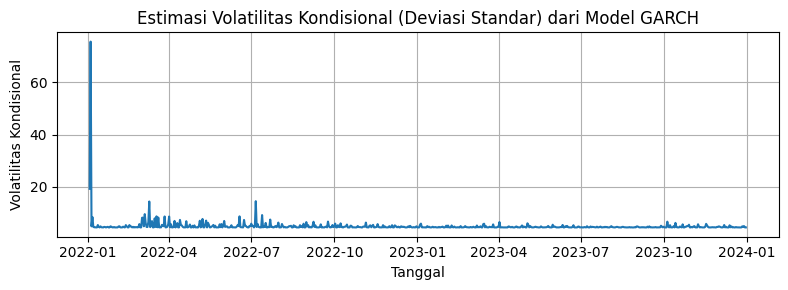

In [ ]:
# Estimasi deviasi standar kondisional (volatilitas) dari model GARCH
conditional_volatility = model_garch_fit.conditional_volatility

# Visualisasikan volatilitas kondisional
plt.figure(figsize=(8, 3))
plt.plot(conditional_volatility.index, conditional_volatility)
plt.title('Estimasi Volatilitas Kondisional (Deviasi Standar) dari Model GARCH')
plt.xlabel('Tanggal')
plt.ylabel('Volatilitas Kondisional')
plt.grid(True)
plt.tight_layout()
plt.show()

Visualisasi volatilitas kondisional seharusnya menunjukkan periode-periode di mana model memperkirakan volatilitas (risiko) pasar lebih tinggi atau lebih rendah. Ini seringkali berkorelasi dengan fluktuasi besar atau kecil pada deret waktu asli.

### Peramalan Volatilitas

Model GARCH juga dapat digunakan untuk meramalkan volatilitas di masa depan.


In [ ]:
# Meramalkan volatilitas untuk periode data uji
# Sesuaikan tanggal start dan end dengan periode data uji kita
start_date_forecast = data_uji.index[0]
end_date_forecast = data_uji.index[-1]

# Peramalan volatilitas
# Gunakan latest_obs untuk menentukan data terakhir yang digunakan model
forecast_garch = model_garch_fit.forecast(horizon=len(data_uji), start=residuals_arima.index[-1])

# Hasil peramalan disimpan dalam objek forecast.
# Variance peramalan ada di forecast.variance
# Deviasi standar peramalan ada di forecast.variance.iloc[-1] (untuk horison peramalan)

# Ekstrak deviasi standar peramalan (volatilitas)
forecast_volatility = forecast_garch.variance.iloc[-1]

# Tampilkan peramalan volatilitas
print("Peramalan Volatilitas (Deviasi Standar) pada Periode Uji:")
print(forecast_volatility)

Peramalan Volatilitas (Deviasi Standar) pada Periode Uji:
h.001      19.821828
h.002      39.457125
h.003      58.916636
h.004      78.377734
h.005      97.838833
            ...     
h.270    5255.561034
h.271    5275.026141
h.272    5294.491262
h.273    5313.956399
h.274    5333.421550
Name: 2023-12-31 00:00:00, Length: 274, dtype: float64


Peramalan volatilitas ini memberikan estimasi risiko atau ketidakpastian untuk periode peramalan. Perhatikan bahwa model GARCH biasanya meramalkan volatilitas yang cenderung kembali ke rata-rata jangka panjang seiring dengan meningkatnya horison peramalan.

## Menggabungkan Model Mean dan Volatilitas untuk Peramalan Harga

Dari notebook sebelumnya, kita telah mengidentifikasi bahwa residual dari model ARIMA(1,1,2) menunjukkan adanya heteroskedastisitas dan tidak berdistribusi normal. Ini mengindikasikan bahwa model ARCH/GARCH cocok untuk memodelkan volatilitas dari residual tersebut.

Kita sudah mengekstrak residual dari model ARIMA(1,1,2) yang dilatih pada data latih dan melatih model GARCH(1,1) pada residual tersebut.

Langkah selanjutnya adalah menggunakan model ARMA-GARCH gabungan untuk peramalan. Dalam konteks ini, kita akan menggunakan model ARIMA(1,1,2) sebagai model mean (karena ARIMA(1,1,2) setara dengan ARMA(1,2) pada data yang telah didifferencing) dan model GARCH(1,1) yang dilatih pada residual ARIMA tersebut untuk memodelkan volatilitas.

Untuk melakukan peramalan dengan model gabungan ini, kita dapat memprediksi nilai mean menggunakan model ARIMA dan memprediksi varians (atau deviasi standar) menggunakan model GARCH.

### ARIMA pada harga + GARCH pada residual (harga langsung)

Data Latih range: 2022-01-03 00:00:00 to 2023-12-31 00:00:00
Data Uji range: 2024-01-01 00:00:00 to 2024-09-30 00:00:00
Jumlah data latih: 728
Jumlah data uji: 274

Fitting ARIMA(1,1,2) model on training data (price)...
ARIMA model fitted successfully.

Fitting GARCH(1,1) with t-distribution on ARIMA residuals...
GARCH model fitted successfully.

Forecasting 274 steps ahead with ARIMA mean model (change in price)...
ARIMA mean change forecast completed.
Forecasting GARCH volatility (of price changes)...
GARCH volatility forecast completed.

Simulating predicted price changes...
Predicted price changes simulated.
Accumulating changes to get predicted prices...
Predicted prices generated.

Evaluating forecast...
Evaluasi Prediksi ARIMA + GARCH:
MAE  : 639.9058
MSE  : 693434.7657
RMSE : 832.7273
MAPE : 850.3869%

Generating visualization...


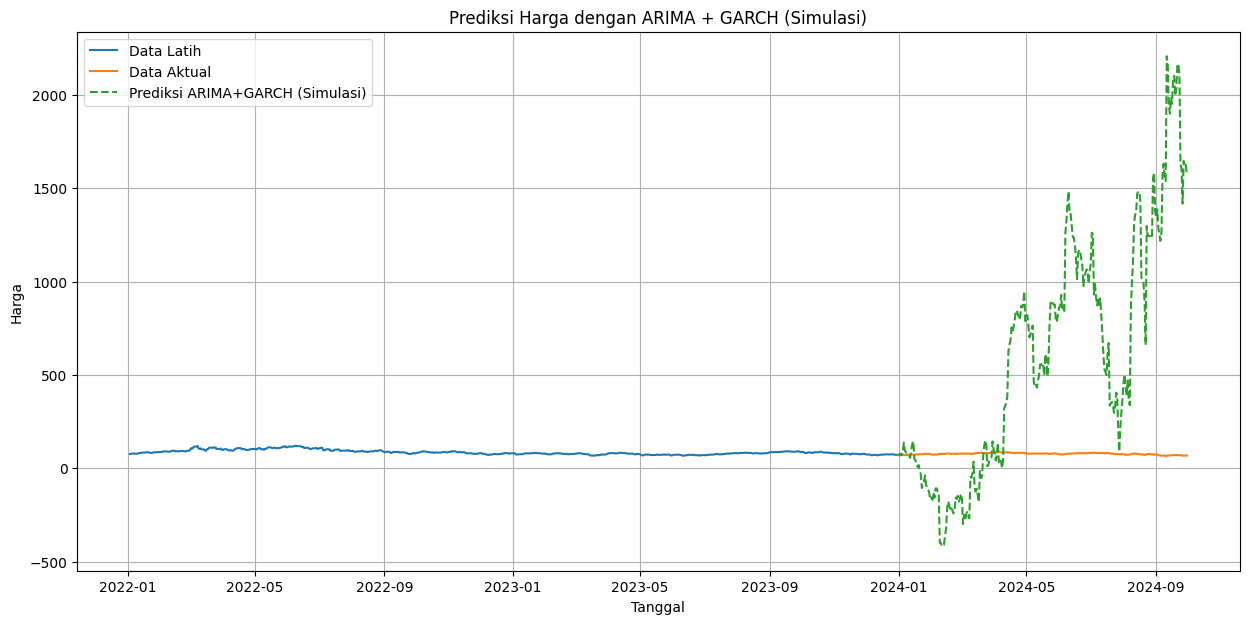

In [ ]:
# Import package yang mungkin diperlukan (pastikan semua sudah diimpor di awal notebook)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Untuk Jarque-Bera jika diperlukan, tapi mungkin tidak langsung dipakai di sini
# from statsmodels.stats.stattools import jarque_bera

# Asumsikan df, data_latih, data_uji, target_column sudah terdefinisi dan data sudah dipreprocessing
# Berdasarkan notebook Anda:
# df = pd.read_csv(...) # dan preprocessing (sorting, set_index, asfreq, bfill)
# split_date = '2024-01-01'
# data_latih = df.loc[df.index < split_date].copy() # Gunakan .loc untuk slicing berbasis indeks
# data_uji = df.loc[df.index >= split_date].copy() # Gunakan .loc untuk slicing berbasis indeks
# target_column = 'price'

print("Data Latih range:", data_latih.index.min(), "to", data_latih.index.max())
print("Data Uji range:", data_uji.index.min(), "to", data_uji.index.max())
print("Jumlah data latih:", len(data_latih))
print("Jumlah data uji:", len(data_uji))


# 2. Fit ARIMA untuk mean return (perubahan harga)
# Fit model ARIMA(1,1,2) pada data harga latih. d=1 artinya memodelkan perubahan.
print("\nFitting ARIMA(1,1,2) model on training data (price)...")
try:
    # Gunakan suppress_warnings=True untuk membersihkan output fit
    model_arima = ARIMA(data_latih[target_column], order=(1,1,2))
    fit_arima = model_arima.fit()
    print("ARIMA model fitted successfully.")
    # print(fit_arima.summary()) # Ringkasan bisa panjang
    arima_fitted = True
except Exception as e:
    print(f"Error fitting ARIMA model: {e}")
    arima_fitted = False

# Lanjutkan hanya jika ARIMA berhasil difit
if arima_fitted:
    # Residual ARIMA dari data latih
    # Ini adalah residual dari model perubahan harga (price_t - price_{t-1})
    residuals_arima = fit_arima.resid
    # Residual ini mungkin punya mean non-zero jika model ARIMA punya konstanta atau tidak fit sempurna

    # 3. Fit GARCH(1,1) pada residual ARIMA
    # Penting: Gunakan distribusi 't' seperti yang Anda temukan lebih baik di notebook
    print("\nFitting GARCH(1,1) with t-distribution on ARIMA residuals...")
    try:
        # Menggunakan mean='Zero' karena ini adalah residual dari model mean
        # GARCH akan memodelkan conditional variance dari residual ini
        model_garch = arch_model(residuals_arima, mean='Zero', vol='Garch', p=1, q=1, dist='t')
        # Gunakan update_freq=0 atau disp='off' untuk mengurangi output saat fitting
        fit_garch = model_garch.fit(disp='off')
        print("GARCH model fitted successfully.")
        # print(fit_garch.summary()) # Ringkasan bisa panjang
        garch_fitted = True
    except Exception as e:
        print(f"Error fitting GARCH model: {e}")
        garch_fitted = False

    # Lanjutkan hanya jika GARCH berhasil difit
    if garch_fitted:
        # 4. Forecast ARIMA mean (perubahan harga) n langkah ke depan
        n_forecast = len(data_uji)
        print(f"\nForecasting {n_forecast} steps ahead with ARIMA mean model (change in price)...")
        try:
            # get_forecast pada model ARIMA(1,1,2) yang difit pada price
            # akan meramalkan level harga, BUKAN perubahan harga secara langsung
            # Untuk mendapatkan peramalan perubahan harga, kita perlu mengambil peramalan level dan menghitung perubahannya
            arima_level_forecast_results = fit_arima.get_forecast(steps=n_forecast)
            arima_level_forecast = arima_level_forecast_results.predicted_mean

            # Peramalan perubahan harga = forecasted_price_t - forecasted_price_{t-1}
            # Untuk langkah pertama, perubahannya adalah forecast_price[0] - last_train_price
            # Untuk langkah selanjutnya, perubahannya adalah forecast_price[i] - forecast_price[i-1]
            last_train_price = data_latih[target_column].iloc[-1]
            mean_change_forecast = [arima_level_forecast.iloc[0] - last_train_price]
            for i in range(1, n_forecast):
                 mean_change_forecast.append(arima_level_forecast.iloc[i] - arima_level_forecast.iloc[i-1])

            # Konversi ke Series pandas dengan indeks data_uji
            mean_change_forecast = pd.Series(mean_change_forecast, index=data_uji.index)
            print("ARIMA mean change forecast completed.")
            # print("Mean Change Forecast head:")
            # print(mean_change_forecast.head())

        except Exception as e:
             print(f"Error during ARIMA forecasting: {e}")
             arima_forecast_ok = False
        else:
             arima_forecast_ok = True


        # 5. Forecast volatilitas GARCH (volatilitas perubahan harga)
        print("Forecasting GARCH volatility (of price changes)...")
        try:
            # forecast() pada model GARCH(1,1) yang difit pada residual perubahan harga
            # akan meramalkan conditional variance dari residual perubahan harga
            garch_forecast_results = fit_garch.forecast(horizon=n_forecast)
            # Ambil variance forecast. variance forecast untuk horizon k ada di kolom ke-k.
            # kita ingin variance forecast untuk horizon 1, 2, ..., n_forecast
            # Ini ada di baris terakhir (sesuai data terakhir yang digunakan untuk fit) dan kolom 0 sampai n_forecast-1
            vol_forecast_variance = garch_forecast_results.variance.values[-1, :]
            vol_forecast = np.sqrt(vol_forecast_variance)
            # Konversi ke Series pandas dengan indeks data_uji untuk kemudahan
            vol_forecast = pd.Series(vol_forecast, index=data_uji.index)
            print("GARCH volatility forecast completed.")
            # print("Volatility Forecast head:")
            # print(vol_forecast.head())
        except Exception as e:
             print(f"Error during GARCH forecasting: {e}")
             garch_forecast_ok = False
        else:
             garch_forecast_ok = True


        # Lanjutkan hanya jika kedua forecast berhasil
        if arima_forecast_ok and garch_forecast_ok:
            # 6. Simulasi prediksi perubahan harga
            # Perubahan harga = mean_change_forecast + noise * vol_forecast
            print("\nSimulating predicted price changes...")
            np.random.seed(42) # Untuk hasil yang repeatable

            # Dapatkan nilai nu (derajat kebebasan) dari model GARCH yang fit
            nu = fit_garch.params['nu']
            # Hasilkan noise dari distribusi t-Student dengan derajat kebebasan nu
            # Noise ini dikalikan dengan volatilitas untuk mendapatkan komponen stochastic
            noise = np.random.standard_t(df=nu, size=n_forecast)

            # Hitung simulated_changes (ini adalah peramalan perubahan harga yang disimulasikan)
            # Pastikan operasi ini elemen demi elemen dan ukurannya sesuai
            simulated_changes = mean_change_forecast.values + noise * vol_forecast.values
            # Konversi kembali ke Series dengan indeks data_uji
            simulated_changes = pd.Series(simulated_changes, index=data_uji.index)

            print("Predicted price changes simulated.")
            # print("Simulated Changes head:")
            # print(simulated_changes.head())


            # 7. Akumulasi perubahan ke harga mulai dari harga terakhir train
            print("Accumulating changes to get predicted prices...")
            # Dapatkan harga terakhir dari data latih
            last_train_price = data_latih[target_column].iloc[-1]

            # Inisialisasi daftar harga yang diprediksi
            predicted_prices_list = [last_train_price] # Mulai dengan harga terakhir train

            # Akumulasikan perubahan yang disimulasikan
            # Loop melalui simulated_changes Series (sudah punya indeks data_uji)
            for change in simulated_changes:
                # Harga berikutnya adalah harga sebelumnya ditambah perubahan yang disimulasikan
                next_price = predicted_prices_list[-1] + change
                predicted_prices_list.append(next_price)

            # Hapus harga awal (harga terakhir data latih) dari daftar predicted_prices_list
            predicted_prices = predicted_prices_list[1:]

            # Konversi hasil akhir ke Series pandas dengan indeks data_uji
            predicted_prices_series = pd.Series(predicted_prices, index=data_uji.index)

            print("Predicted prices generated.")
            # print("Predicted Prices Series head:")
            # print(predicted_prices_series.head())

            # 8. Evaluasi
            # Pastikan test_prices adalah Series/array dari harga aktual pada periode uji
            test_prices = data_uji[target_column]

            print("\nEvaluating forecast...")
            try:
                mae = mean_absolute_error(test_prices, predicted_prices_series)
                mse = mean_squared_error(test_prices, predicted_prices_series)
                rmse = np.sqrt(mse)
                # Hindari pembagian dengan nol di MAPE, gunakan toleransi kecil 1e-8
                mape = np.mean(np.abs((test_prices - predicted_prices_series) / (test_prices + 1e-8))) * 100

                print(f"Evaluasi Prediksi ARIMA + GARCH:")
                print(f"MAE  : {mae:.4f}")
                print(f"MSE  : {mse:.4f}")
                print(f"RMSE : {rmse:.4f}")
                print(f"MAPE : {mape:.4f}%")
            except Exception as e:
                 print(f"Error during evaluation: {e}")


            # 9. Visualisasi
            print("\nGenerating visualization...")
            try:
                plt.figure(figsize=(15,7))
                # Plot data latih
                plt.plot(data_latih.index, data_latih[target_column], label='Data Latih')
                # Plot data aktual (uji)
                plt.plot(data_uji.index, data_uji[target_column], label='Data Aktual')
                # Plot prediksi menggunakan indeks data_uji
                plt.plot(predicted_prices_series.index, predicted_prices_series, label='Prediksi ARIMA+GARCH (Simulasi)', linestyle='--')
                plt.title('Prediksi Harga dengan ARIMA + GARCH (Simulasi)')
                plt.xlabel('Tanggal')
                plt.ylabel('Harga')
                plt.legend()
                plt.grid(True)
                plt.show()
            except Exception as e:
                 print(f"Error during visualization: {e}")
        else:
            print("\nSkipping simulation, evaluation, and visualization due to previous errors.")
    else:
        print("\nSkipping GARCH forecast, simulation, evaluation, and visualization due to GARCH fit error.")
else:
    print("\nSkipping ARIMA forecast, GARCH fit/forecast, simulation, evaluation, and visualization due to ARIMA fit error.")

### ARIMA pada log returns + GARCH pada residual (log returns)


--- Modeling on Log Returns ---
Log Returns Latih range: 2022-01-04 00:00:00 to 2023-12-31 00:00:00
Log Returns Uji range: 2024-01-01 00:00:00 to 2024-09-30 00:00:00

Fitting ARMA model on training log returns...
ARMA model fitted successfully.

Fitting GARCH(1,1) with t-distribution on ARMA log return residuals...
GARCH model fitted successfully.

Forecasting 274 steps ahead with ARMA mean model (log returns)...
ARMA mean log return forecast completed.
Forecasting GARCH volatility (of log returns)...
GARCH volatility forecast completed.

Simulating predicted log returns...
Predicted log returns simulated.
Accumulating log returns to get predicted prices...
Predicted prices generated from log returns.

Evaluating forecast (on original price scale)...
Evaluasi Prediksi ARMA(Log Returns) + GARCH(Log Returns Residuals):
MAE  : 18.7563
MSE  : 456.0797
RMSE : 21.3560
MAPE : 24.2163%

Generating visualization...


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004739. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


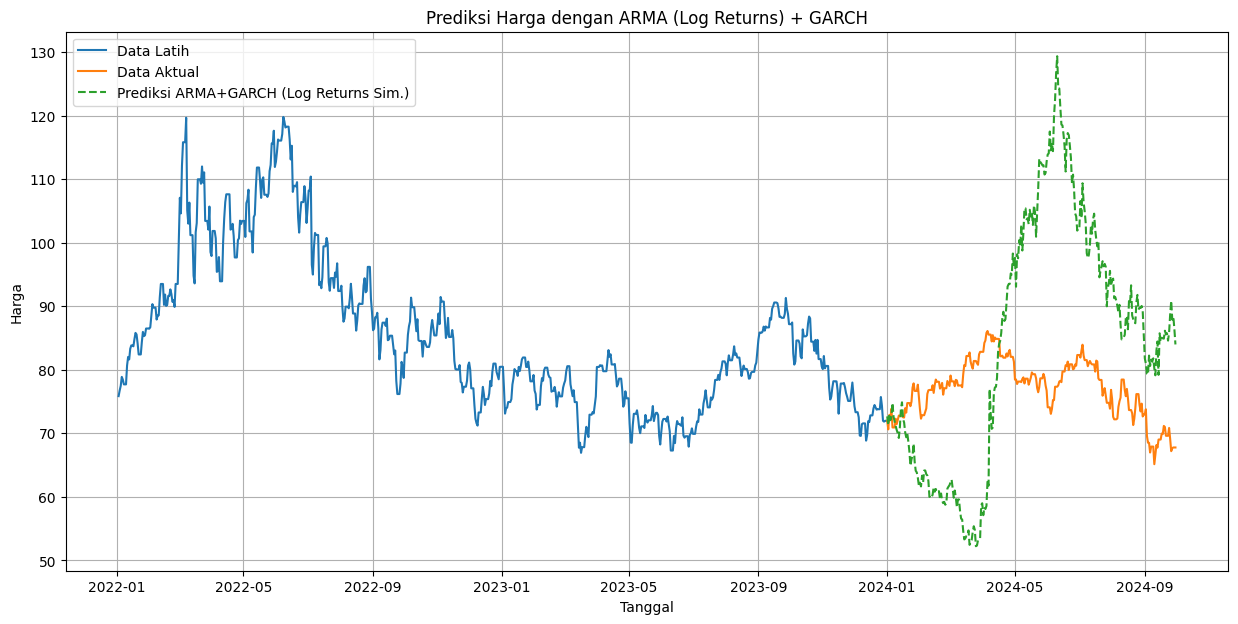

In [ ]:
# --- Contoh Modifikasi: Pemodelan pada Log Returns ---
# Langkah 1: Hitung Log Returns
df_log = df.copy()
df_log[target_column + '_log'] = np.log(df_log[target_column])
df_log_returns = df_log[target_column + '_log'].diff().dropna()

# Bagi log returns menjadi data latih dan uji
log_returns_latih = df_log_returns.loc[df_log_returns.index < split_date].copy()
log_returns_uji = df_log_returns.loc[df_log_returns.index >= split_date].copy()

print("\n--- Modeling on Log Returns ---")
print("Log Returns Latih range:", log_returns_latih.index.min(), "to", log_returns_latih.index.max())
print("Log Returns Uji range:", log_returns_uji.index.min(), "to", log_returns_uji.index.max())


# Langkah 2 (Modifikasi): Fit ARMA pada Log Returns
# Biasanya log returns stasioner, jadi d=0 untuk ARMA
# Ordo p dan q perlu dicari dari ACF/PACF log returns
# Contoh: ARMA(1,1). Anda perlu cek ACF/PACF dari log_returns_latih
# Atau gunakan auto_arima pada log_returns_latih untuk mencari ordo ARMA terbaik
print("\nFitting ARMA model on training log returns...")
try:
    # Ordo ARMA(p,q), d=0 karena pada log returns yang stasioner
    # Ganti (1,0,1) dengan ordo ARMA yang Anda tentukan dari analisis log returns
    model_arma = ARIMA(log_returns_latih, order=(1,0,1))
    fit_arma = model_arma.fit()
    print("ARMA model fitted successfully.")
    # print(fit_arma.summary())
    arma_fitted = True
except Exception as e:
    print(f"Error fitting ARMA model: {e}")
    arma_fitted = False

if arma_fitted:
    # Residual ARMA (dari log returns)
    residuals_arma_returns = fit_arma.resid

    # Langkah 3 (Modifikasi): Fit GARCH pada Residual ARMA dari Log Returns
    print("\nFitting GARCH(1,1) with t-distribution on ARMA log return residuals...")
    try:
        # Menggunakan mean='Zero' pada residual
        model_garch_returns = arch_model(residuals_arma_returns, mean='Zero', vol='Garch', p=1, q=1, dist='t')
        fit_garch_returns = model_garch_returns.fit(disp='off')
        print("GARCH model fitted successfully.")
        # print(fit_garch_returns.summary())
        garch_returns_fitted = True
    except Exception as e:
        print(f"Error fitting GARCH model on returns: {e}")
        garch_returns_fitted = False

    if garch_returns_fitted:
        # Langkah 4 (Modifikasi): Forecast Mean Log Return n langkah ke depan
        n_forecast = len(log_returns_uji)
        print(f"\nForecasting {n_forecast} steps ahead with ARMA mean model (log returns)...")
        try:
            arma_returns_forecast_results = fit_arma.get_forecast(steps=n_forecast)
            mean_log_return_forecast = arma_returns_forecast_results.predicted_mean
            # Tambahkan indeks waktu yang sesuai
            mean_log_return_forecast.index = log_returns_uji.index
            print("ARMA mean log return forecast completed.")
            # print("Mean Log Return Forecast head:")
            # print(mean_log_return_forecast.head())
        except Exception as e:
             print(f"Error during ARMA forecasting: {e}")
             arma_forecast_ok = False
        else:
             arma_forecast_ok = True

        # Langkah 5 (Modifikasi): Forecast Volatilitas GARCH (volatilitas log returns)
        print("Forecasting GARCH volatility (of log returns)...")
        try:
            garch_returns_forecast_results = fit_garch_returns.forecast(horizon=n_forecast)
            vol_log_return_forecast_variance = garch_returns_forecast_results.variance.values[-1, :]
            vol_log_return_forecast = np.sqrt(vol_log_return_forecast_variance)
            # Konversi ke Series pandas dengan indeks log_returns_uji
            vol_log_return_forecast = pd.Series(vol_log_return_forecast, index=log_returns_uji.index)
            print("GARCH volatility forecast completed.")
            # print("Volatility Log Return Forecast head:")
            # print(vol_log_return_forecast.head())
        except Exception as e:
             print(f"Error during GARCH forecasting: {e}")
             garch_forecast_ok = False
        else:
             garch_forecast_ok = True

        # Lanjutkan hanya jika kedua forecast berhasil
        if arma_forecast_ok and garch_forecast_ok:
            # Langkah 6 (Modifikasi): Simulasi prediksi Log Returns
            # Log Returns = mean_log_return_forecast + noise * vol_log_return_forecast
            print("\nSimulating predicted log returns...")
            np.random.seed(42) # Untuk hasil yang repeatable

            # Dapatkan nilai nu (derajat kebebasan) dari model GARCH yang fit pada returns
            nu_returns = fit_garch_returns.params['nu']
            # Hasilkan noise dari distribusi t-Student
            noise_returns = np.random.standard_t(df=nu_returns, size=n_forecast)

            # Hitung simulated_log_returns
            # Ini adalah peramalan log returns yang disimulasikan
            simulated_log_returns = mean_log_return_forecast.values + noise_returns * vol_log_return_forecast.values
            # Konversi kembali ke Series dengan indeks log_returns_uji
            simulated_log_returns = pd.Series(simulated_log_returns, index=log_returns_uji.index)

            print("Predicted log returns simulated.")
            # print("Simulated Log Returns head:")
            # print(simulated_log_returns.head())

            # Langkah 7 (Modifikasi): Akumulasi Log Returns ke Log Harga, lalu Eksponensialkan ke Harga Asli
            print("Accumulating log returns to get predicted prices...")
            # Dapatkan log harga terakhir dari data latih asli (sebelum diff)
            last_train_price_log = df_log[target_column + '_log'].loc[data_latih.index[-1]]

            # Inisialisasi daftar log harga yang diprediksi
            predicted_log_prices_list = [last_train_price_log] # Mulai dengan log harga terakhir train

            # Akumulasikan log returns yang disimulasikan
            # log(P_t) = log(P_{t-1}) + r_t
            for log_return in simulated_log_returns:
                next_log_price = predicted_log_prices_list[-1] + log_return
                predicted_log_prices_list.append(next_log_price)

            # Hapus log harga awal dari daftar
            predicted_log_prices = predicted_log_prices_list[1:]

            # Transformasi kembali ke skala harga asli
            predicted_prices = np.exp(predicted_log_prices)

            # Konversi hasil akhir ke Series pandas dengan indeks data_uji
            predicted_prices_series = pd.Series(predicted_prices, index=data_uji.index)

            print("Predicted prices generated from log returns.")
            # print("Predicted Prices Series head:")
            # print(predicted_prices_series.head())

            # Langkah 8. Evaluasi (Sama seperti sebelumnya, pada harga asli)
            test_prices = data_uji[target_column]
            print("\nEvaluating forecast (on original price scale)...")
            try:
                mae = mean_absolute_error(test_prices, predicted_prices_series)
                mse = mean_squared_error(test_prices, predicted_prices_series)
                rmse = np.sqrt(mse)
                mape = np.mean(np.abs((test_prices - predicted_prices_series) / (test_prices + 1e-8))) * 100

                print(f"Evaluasi Prediksi ARMA(Log Returns) + GARCH(Log Returns Residuals):")
                print(f"MAE  : {mae:.4f}")
                print(f"MSE  : {mse:.4f}")
                print(f"RMSE : {rmse:.4f}")
                print(f"MAPE : {mape:.4f}%")
            except Exception as e:
                 print(f"Error during evaluation: {e}")

            # Langkah 9. Visualisasi (Sama seperti sebelumnya)
            print("\nGenerating visualization...")
            try:
                plt.figure(figsize=(15,7))
                plt.plot(data_latih.index, data_latih[target_column], label='Data Latih')
                plt.plot(data_uji.index, data_uji[target_column], label='Data Aktual')
                plt.plot(predicted_prices_series.index, predicted_prices_series, label='Prediksi ARMA+GARCH (Log Returns Sim.)', linestyle='--')
                plt.title('Prediksi Harga dengan ARMA (Log Returns) + GARCH')
                plt.xlabel('Tanggal')
                plt.ylabel('Harga')
                plt.legend()
                plt.grid(True)
                plt.show()
            except Exception as e:
                 print(f"Error during visualization: {e}")
        else:
            print("\nSkipping simulation, evaluation, and visualization due to forecasting errors.")
    else:
        print("\nSkipping GARCH fit/forecast, simulation, evaluation, and visualization due to GARCH fit error.")
else:
    print("\nSkipping ARMA fit/forecast, GARCH fit/forecast, simulation, evaluation, and visualization due to ARMA fit error.")

### ARIMA pada log returns + GARCH + Simulasi Monte Carlo (multiple paths)


Running 1000 Monte Carlo simulations...
Simulations completed.

Evaluating forecast (using average of simulations)...
Evaluasi Prediksi ARMA(Log Returns) + GARCH (Average of 1000 Simulations):
MAE  : 4.8213
MSE  : 32.7794
RMSE : 5.7253
MAPE : 6.1824%

Generating visualization...


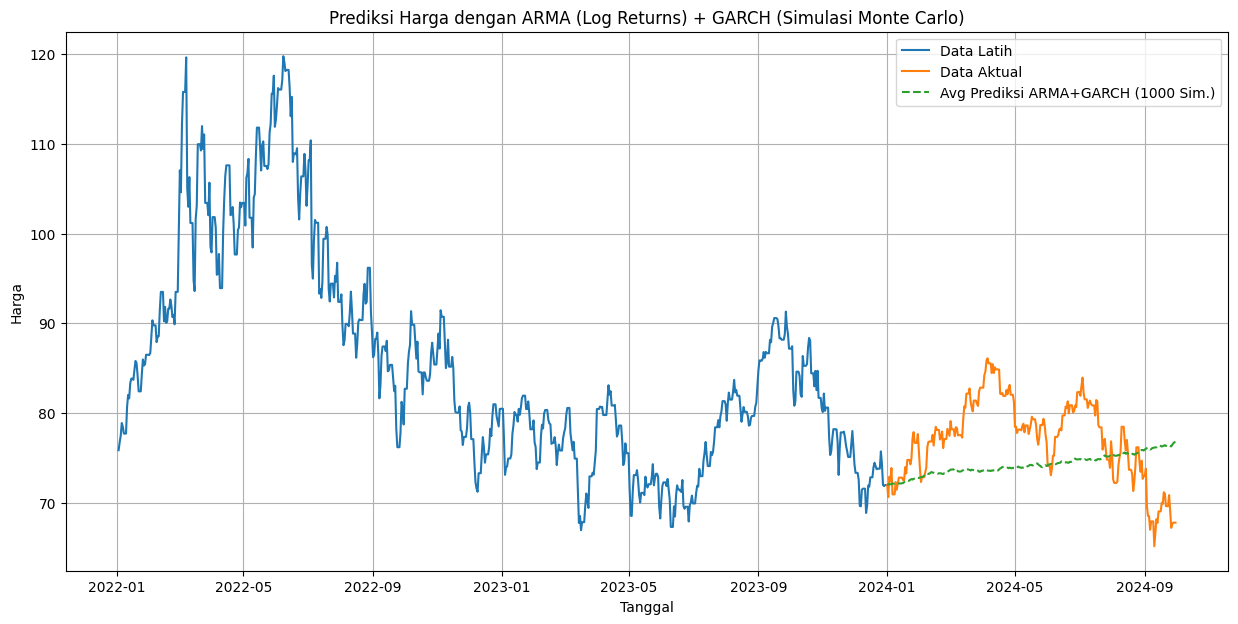

In [ ]:
# Contoh struktur penambahan simulasi Monte Carlo multipel jalur (hanya kerangka)

# ... (Fit ARMA dan GARCH pada log returns) ...

# Jumlah jalur simulasi
n_simulations = 1000 # Coba 1000 atau 10000

# Daftar untuk menyimpan hasil prediksi harga dari setiap jalur simulasi
all_simulated_prices = []

print(f"\nRunning {n_simulations} Monte Carlo simulations...")

# Loop untuk menjalankan simulasi berkali-kali
for i in range(n_simulations):
    # Langkah 6 (Modifikasi): Simulasi prediksi Log Returns (untuk satu jalur)
    # Gunakan seed yang berbeda atau hapus np.random.seed(42) di dalam loop
    # jika Anda ingin hasil simulasi yang benar-benar berbeda antar jalur
    # np.random.seed(42 + i) # Contoh menggunakan seed berbeda

    nu_returns = fit_garch_returns.params['nu']
    noise_returns = np.random.standard_t(df=nu_returns, size=n_forecast)
    simulated_log_returns = mean_log_return_forecast.values + noise_returns * vol_log_return_forecast.values
    simulated_log_returns = pd.Series(simulated_log_returns, index=log_returns_uji.index)


    # Langkah 7 (Modifikasi): Akumulasi Log Returns ke Log Harga, lalu Eksponensialkan ke Harga Asli (untuk satu jalur)
    last_train_price_log = df_log[target_column + '_log'].loc[data_latih.index[-1]]
    predicted_log_prices_list = [last_train_price_log]
    for log_return in simulated_log_returns:
        next_log_price = predicted_log_prices_list[-1] + log_return
        predicted_log_prices_list.append(next_log_price)
    predicted_log_prices = predicted_log_prices_list[1:]
    predicted_prices_single_path = np.exp(predicted_log_prices)

    # Simpan hasil prediksi harga dari jalur ini
    all_simulated_prices.append(predicted_prices_single_path)

print("Simulations completed.")

# Langkah 8 (Modifikasi): Hitung Rata-rata Prediksi dari Semua Jalur dan Evaluasi
# Konversi list of arrays/Series menjadi array numpy 2D (jalur x waktu)
all_simulated_prices_array = np.array(all_simulated_prices)

# Hitung rata-rata prediksi untuk setiap titik waktu peramalan
average_predicted_prices = np.mean(all_simulated_prices_array, axis=0)
# Konversi kembali ke Series dengan indeks data_uji
average_predicted_prices_series = pd.Series(average_predicted_prices, index=data_uji.index)

print("\nEvaluating forecast (using average of simulations)...")
test_prices = data_uji[target_column]

try:
    mae = mean_absolute_error(test_prices, average_predicted_prices_series)
    mse = mean_squared_error(test_prices, average_predicted_prices_series)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test_prices - average_predicted_prices_series) / (test_prices + 1e-8))) * 100

    print(f"Evaluasi Prediksi ARMA(Log Returns) + GARCH (Average of {n_simulations} Simulations):")
    print(f"MAE  : {mae:.4f}")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAPE : {mape:.4f}%")
except Exception as e:
     print(f"Error during evaluation: {e}")

# Langkah 9 (Modifikasi): Visualisasi (Plot Data Aktual dan Rata-rata Prediksi)
print("\nGenerating visualization...")
try:
    plt.figure(figsize=(15,7))
    plt.plot(data_latih.index, data_latih[target_column], label='Data Latih')
    plt.plot(data_uji.index, data_uji[target_column], label='Data Aktual')
    # Plot rata-rata prediksi
    plt.plot(average_predicted_prices_series.index, average_predicted_prices_series, label=f'Avg Prediksi ARMA+GARCH ({n_simulations} Sim.)', linestyle='--')

    # Opsional: Plot beberapa jalur simulasi individual (bisa membuat plot ramai)
    # for i in range(min(10, n_simulations)): # Plot max 10 jalur contoh
    #    plt.plot(average_predicted_prices_series.index, all_simulated_prices[i], linestyle=':', color='grey', alpha=0.3)

    plt.title('Prediksi Harga dengan ARMA (Log Returns) + GARCH (Simulasi Monte Carlo)')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga')
    plt.legend()
    plt.grid(True)
    plt.show()
except Exception as e:
     print(f"Error during visualization: {e}")

ini adalah hasil terbaik, dengan metrik evaluasi

Evaluating forecast (using average of simulations)...

Evaluasi Prediksi ARMA(Log Returns) + GARCH (Average of 1000 Simulations):

MAE  : 4.8213

MSE  : 32.7794

RMSE : 5.7253

MAPE : 6.1824%

Kita akan jadikan ini penutup. Beyond ARIMA.

In [ ]:
import pickle
import os

# Definisikan direktori untuk menyimpan model
model_dir = 'saved_models'
os.makedirs(model_dir, exist_ok=True) # Buat direktori jika belum ada

# Definisikan nama file untuk setiap model
arma_filename = os.path.join(model_dir, 'arma_log_returns_model.pkl')
garch_filename = os.path.join(model_dir, 'garch_log_returns_model.pkl')

# Menyimpan model ARMA
if 'fit_arma' in locals() and fit_arma is not None:
    try:
        with open(arma_filename, 'wb') as f:
            pickle.dump(fit_arma, f)
        print(f"Model ARMA berhasil disimpan ke '{arma_filename}'")
    except Exception as e:
        print(f"Gagal menyimpan model ARMA: {e}")
else:
    print("Model ARMA belum fit atau tidak ditemukan.")


# Menyimpan model GARCH
if 'fit_garch_returns' in locals() and fit_garch_returns is not None:
    try:
        with open(garch_filename, 'wb') as f:
            pickle.dump(fit_garch_returns, f)
        print(f"Model GARCH berhasil disimpan ke '{garch_filename}'")
    except Exception as e:
        print(f"Gagal menyimpan model GARCH: {e}")
else:
    print("Model GARCH belum fit atau tidak ditemukan.")

Model ARMA berhasil disimpan ke 'saved_models/arma_log_returns_model.pkl'
Model GARCH berhasil disimpan ke 'saved_models/garch_log_returns_model.pkl'


In [ ]:
import pickle
import os
from statsmodels.tsa.arima.model import ARIMA # Perlu impor kelas modelnya
from arch import arch_model # Perlu impor kelas modelnya

# Definisikan path file model (sesuai saat menyimpan)
model_dir = 'saved_models'
arma_filename = os.path.join(model_dir, 'arma_log_returns_model.pkl')
garch_filename = os.path.join(model_dir, 'garch_log_returns_model.pkl')

# Memuat model ARMA
loaded_fit_arma = None
if os.path.exists(arma_filename):
    try:
        with open(arma_filename, 'rb') as f:
            loaded_fit_arma = pickle.load(f)
        print(f"Model ARMA berhasil dimuat dari '{arma_filename}'")
        # print(loaded_fit_arma.summary()) # Opsional: cek ringkasan
    except Exception as e:
        print(f"Gagal memuat model ARMA: {e}")
else:
    print(f"File model ARMA tidak ditemukan di '{arma_filename}'.")

# Memuat model GARCH
loaded_fit_garch_returns = None
if os.path.exists(garch_filename):
    try:
        with open(garch_filename, 'rb') as f:
            loaded_fit_garch_returns = pickle.load(f)
        print(f"Model GARCH berhasil dimuat dari '{garch_filename}'")
        # print(loaded_fit_garch_returns.summary()) # Opsional: cek ringkasan
    except Exception as e:
        print(f"Gagal memuat model GARCH: {e}")
else:
    print(f"File model GARCH tidak ditemukan di '{garch_filename}'.")

# Sekarang Anda bisa menggunakan loaded_fit_arma dan loaded_fit_garch_returns
# untuk melakukan peramalan (langkah 4 dan 5) dan simulasi (langkah 6 dan 7)
# tanpa perlu melatih ulang model.

# Contoh penggunaan untuk forecast:
# if loaded_fit_arma is not None and loaded_fit_garch_returns is not None:
#    n_forecast = len(data_uji) # Atau jumlah hari yang ingin diramal
#    mean_log_return_forecast = loaded_fit_arma.get_forecast(steps=n_forecast).predicted_mean
#    garch_forecast_results = loaded_fit_garch_returns.forecast(horizon=n_forecast)
#    vol_log_return_forecast = np.sqrt(garch_forecast_results.variance.values[-1, :])
#    # ... lanjutkan dengan simulasi menggunakan forecast results ...

Model ARMA berhasil dimuat dari 'saved_models/arma_log_returns_model.pkl'
Model GARCH berhasil dimuat dari 'saved_models/garch_log_returns_model.pkl'



Running 10000 Monte Carlo simulations...
Simulations completed.

Evaluating forecast (using average of simulations)...
Evaluasi Prediksi ARMA(Log Returns) + GARCH (Average of 10000 Simulations):
MAE  : 4.8677
MSE  : 33.1372
RMSE : 5.7565
MAPE : 6.2702%

Generating visualization...


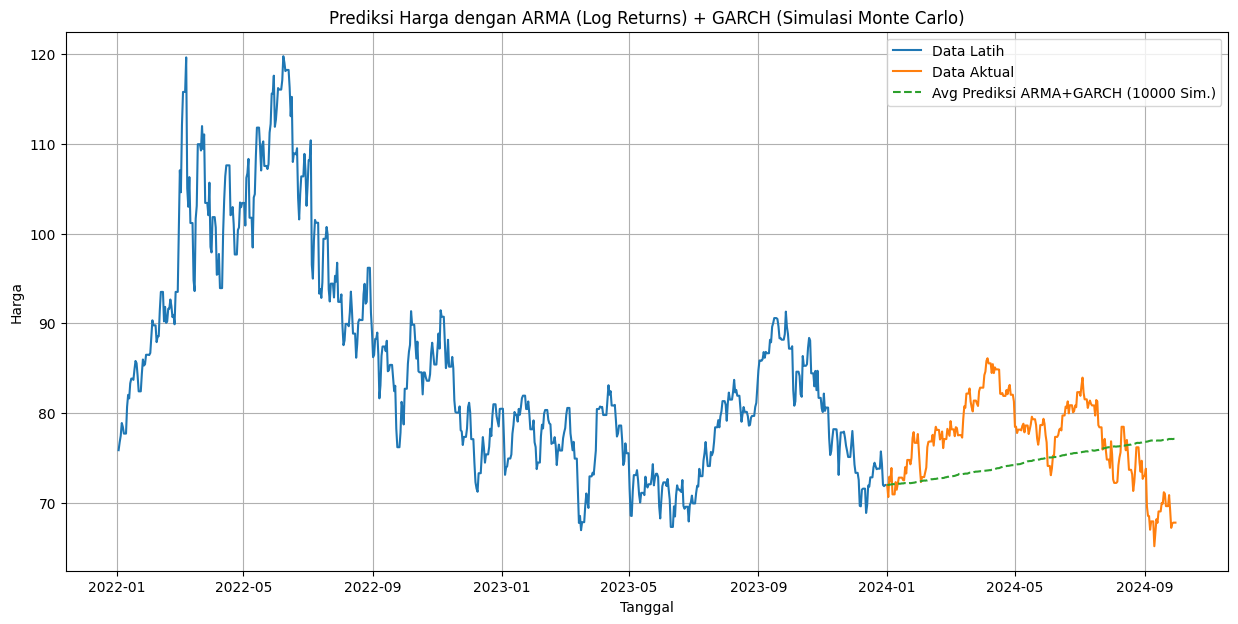

In [ ]:
# Contoh struktur penambahan simulasi Monte Carlo multipel jalur (hanya kerangka)

# ... (Fit ARMA dan GARCH pada log returns) ...

# Jumlah jalur simulasi
n_simulations = 10000 # Coba 1000 atau 10000

# Daftar untuk menyimpan hasil prediksi harga dari setiap jalur simulasi
all_simulated_prices = []

print(f"\nRunning {n_simulations} Monte Carlo simulations...")

# Loop untuk menjalankan simulasi berkali-kali
for i in range(n_simulations):
    # Langkah 6 (Modifikasi): Simulasi prediksi Log Returns (untuk satu jalur)
    # Gunakan seed yang berbeda atau hapus np.random.seed(42) di dalam loop
    # jika Anda ingin hasil simulasi yang benar-benar berbeda antar jalur
    # np.random.seed(42 + i) # Contoh menggunakan seed berbeda

    nu_returns = fit_garch_returns.params['nu']
    noise_returns = np.random.standard_t(df=nu_returns, size=n_forecast)
    simulated_log_returns = mean_log_return_forecast.values + noise_returns * vol_log_return_forecast.values
    simulated_log_returns = pd.Series(simulated_log_returns, index=log_returns_uji.index)


    # Langkah 7 (Modifikasi): Akumulasi Log Returns ke Log Harga, lalu Eksponensialkan ke Harga Asli (untuk satu jalur)
    last_train_price_log = df_log[target_column + '_log'].loc[data_latih.index[-1]]
    predicted_log_prices_list = [last_train_price_log]
    for log_return in simulated_log_returns:
        next_log_price = predicted_log_prices_list[-1] + log_return
        predicted_log_prices_list.append(next_log_price)
    predicted_log_prices = predicted_log_prices_list[1:]
    predicted_prices_single_path = np.exp(predicted_log_prices)

    # Simpan hasil prediksi harga dari jalur ini
    all_simulated_prices.append(predicted_prices_single_path)

print("Simulations completed.")

# Langkah 8 (Modifikasi): Hitung Rata-rata Prediksi dari Semua Jalur dan Evaluasi
# Konversi list of arrays/Series menjadi array numpy 2D (jalur x waktu)
all_simulated_prices_array = np.array(all_simulated_prices)

# Hitung rata-rata prediksi untuk setiap titik waktu peramalan
average_predicted_prices = np.mean(all_simulated_prices_array, axis=0)
# Konversi kembali ke Series dengan indeks data_uji
average_predicted_prices_series = pd.Series(average_predicted_prices, index=data_uji.index)

print("\nEvaluating forecast (using average of simulations)...")
test_prices = data_uji[target_column]

try:
    mae = mean_absolute_error(test_prices, average_predicted_prices_series)
    mse = mean_squared_error(test_prices, average_predicted_prices_series)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test_prices - average_predicted_prices_series) / (test_prices + 1e-8))) * 100

    print(f"Evaluasi Prediksi ARMA(Log Returns) + GARCH (Average of {n_simulations} Simulations):")
    print(f"MAE  : {mae:.4f}")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAPE : {mape:.4f}%")
except Exception as e:
     print(f"Error during evaluation: {e}")

# Langkah 9 (Modifikasi): Visualisasi (Plot Data Aktual dan Rata-rata Prediksi)
print("\nGenerating visualization...")
try:
    plt.figure(figsize=(15,7))
    plt.plot(data_latih.index, data_latih[target_column], label='Data Latih')
    plt.plot(data_uji.index, data_uji[target_column], label='Data Aktual')
    # Plot rata-rata prediksi
    plt.plot(average_predicted_prices_series.index, average_predicted_prices_series, label=f'Avg Prediksi ARMA+GARCH ({n_simulations} Sim.)', linestyle='--')

    # Opsional: Plot beberapa jalur simulasi individual (bisa membuat plot ramai)
    # for i in range(min(10, n_simulations)): # Plot max 10 jalur contoh
    #    plt.plot(average_predicted_prices_series.index, all_simulated_prices[i], linestyle=':', color='grey', alpha=0.3)

    plt.title('Prediksi Harga dengan ARMA (Log Returns) + GARCH (Simulasi Monte Carlo)')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga')
    plt.legend()
    plt.grid(True)
    plt.show()
except Exception as e:
     print(f"Error during visualization: {e}")

## Evaluasi dan Perbandingan Model Lanjutan


Sebelumnya kita telah mengeksplorasi model SARIMA (dan menyimpulkan bahwa komponen musiman mungkin tidak signifikan), menerapkan transformasi logaritmik untuk menstabilkan varians, dan memodelkan volatilitas menggunakan GARCH pada residual model ARIMA dari data asli.

Sekarang, kita akan melatih model mean (ARIMA atau SARIMA) pada data yang telah ditransformasi logaritmik. Tujuan langkah ini adalah untuk melihat apakah transformasi data di awal pipeline dapat meningkatkan kinerja model mean, khususnya terkait asumsi distribusi residual dan heteroskedastisitas, sebelum mempertimbangkan model volatilitas tambahan jika masih diperlukan.

### Melatih Model ARIMA pada Data yang Ditransformasi Logaritmik

Berdasarkan analisis ACF dan PACF pada data yang telah ditransformasi logaritmik dan didifferencing, ordo $(p,d,q) = (1,1,1)$$(p,d,q) = (1,1,1)$ atau $(1,1,2)$$(1,1,2)$ masih menjadi kandidat kuat untuk komponen non-musiman. Kita akan mencoba melatih model ARIMA dengan ordo tersebut pada data latih yang telah ditransformasi logaritmik.

Kita akan menggunakan data latih yang sudah dibagi (`data_latih`) dan menerapkan transformasi logaritmik hanya pada data latih ini.

Data latih asli (price) dan data latih setelah transformasi logaritmik (price_log):
            price   open   high    low     vol-k  change-%  price_log
date                                                                 
2022-01-03  75.85  75.53  76.18  74.01  112230.0      1.30   4.328758
2022-01-04  76.74  75.80  77.40  75.47  156450.0      1.17   4.340423
2022-01-05  77.47  76.88  78.16  76.25  197970.0      0.95   4.349891
2022-01-06  78.88  76.79  79.56  76.28  244000.0      1.82   4.367928
2022-01-07  78.44  79.00  79.82  78.07  229280.0     -0.56   4.362334

Melatih Model ARIMA(1,1,1) pada data latih yang ditransformasi log...

Ringkasan Model ARIMA pada Data yang Ditransformasi Log:
                               SARIMAX Results                                
Dep. Variable:              price_log   No. Observations:                  728
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1750.826
Date:                Wed, 11 Jun 2025   AIC                 

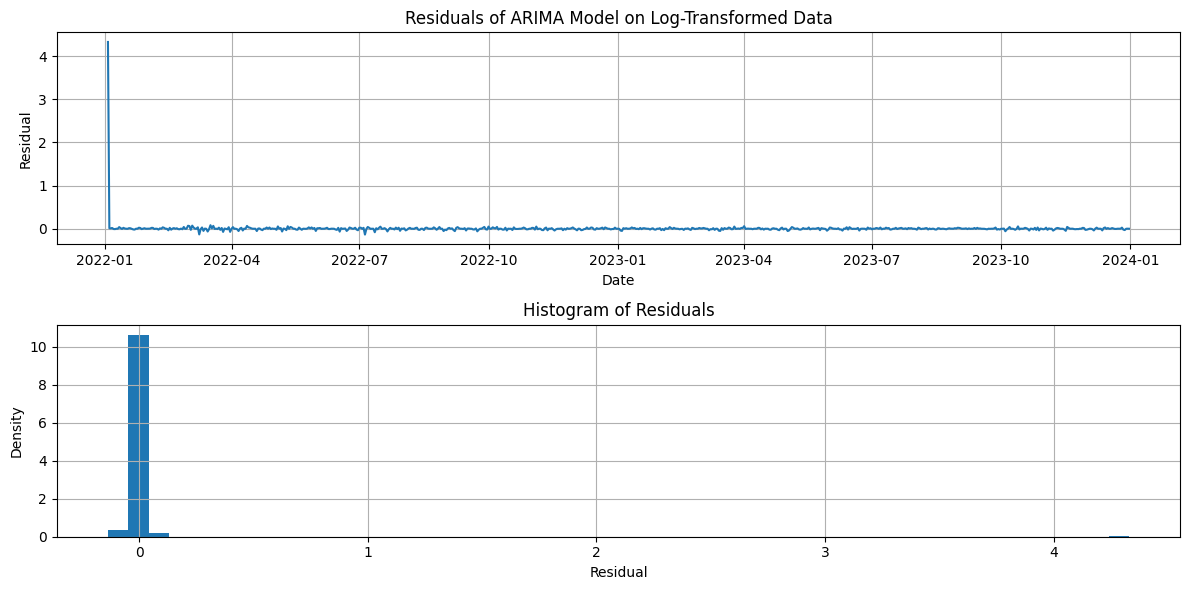

In [ ]:
# Import package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch # Import het_arch
from statsmodels.stats.stattools import jarque_bera
import statsmodels.api as sm

# Asumsi data_latih sudah terdefinisi dari langkah sebelumnya

# Menerapkan transformasi logaritmik pada data latih
data_latih_transformed = data_latih.copy()
data_latih_transformed[target_column + '_log'] = np.log(data_latih_transformed[target_column])

# Definisikan kolom target yang baru setelah transformasi pada data latih
target_column_transformed_latih = target_column + '_log'

print(f"Data latih asli ({target_column}) dan data latih setelah transformasi logaritmik ({target_column_transformed_latih}):")
print(data_latih_transformed.head())

# Definisikan ordo ARIMA yang akan dicoba pada data yang ditransformasi
# Berdasarkan analisis ACF/PACF sebelumnya pada data ditransformasi & didifferencing
# Ordo (1,1,1) dan (1,1,2) adalah kandidat
p_order = 1
d_order = 1 # d=1 karena data yang ditransformasi masih butuh differencing
q_order = 1

# Latih model ARIMA(p,d,q) pada data latih yang sudah ditransformasi logaritmik
print(f"\nMelatih Model ARIMA({p_order},{d_order},{q_order}) pada data latih yang ditransformasi log...")

# Menggunakan try-except untuk menangani potensi error selama pelatihan
try:
    model_arima_transformed = ARIMA(data_latih_transformed[target_column_transformed_latih], order=(p_order, d_order, q_order))
    model_arima_transformed_fit = model_arima_transformed.fit()

    print("\nRingkasan Model ARIMA pada Data yang Ditransformasi Log:")
    print(model_arima_transformed_fit.summary())

    # Ekstrak residual dari model yang dilatih
    residuals_arima_transformed = model_arima_transformed_fit.resid

    # --- Diagnostik Residual ---
    print("\n--- Diagnostik Residual Model ARIMA pada Data yang Ditransformasi Log ---")

    # 1. Uji Ljung-Box pada Residual
    # Memeriksa sisa autokorelasi pada residual
    # Jumlah lags default di statsmodels adalah 40 jika tidak specified, atau floor(nobs/5)
    # Kita bisa menentukan lags, pastikan tidak lebih dari jumlah observasi residual - 1
    max_lags_lb = min(40, len(residuals_arima_transformed) // 2 - 1)
    ljungbox_results_transformed = acorr_ljungbox(residuals_arima_transformed, lags=max_lags_lb, return_df=True)
    print(f"\nLjung-Box Test on Residuals (up to {max_lags_lb} lags):")
    print(ljungbox_results_transformed.head()) # Tampilkan beberapa baris pertama

    # 2. Uji Jarque-Bera pada Residual
    # Memeriksa normalitas residual
    jb_test_transformed = jarque_bera(residuals_arima_transformed)
    print(f"\nJarque-Bera Test on Residuals:")
    print(f"Statistic: {jb_test_transformed[0]:.4f}, p-value: {jb_test_transformed[1]:.4f}")

    # 3. Uji Heteroskedasticity (ARCH Test) pada Residual
    # Memeriksa varians yang tidak konstan pada residual
    # Gunakan nlags=10
    arch_test_transformed = het_arch(residuals_arima_transformed, nlags=10) # Menggunakan nlags=10
    print(f"\nARCH Test on Residuals (Heteroskedasticity) with {10} lags:")
    print(f"Lagrange multiplier statistic: {arch_test_transformed[0]:.4f}")
    print(f"p-value (Heteroskedasticity): {arch_test_transformed[1]:.4f}")
    # Arch test mengembalikan beberapa nilai, [0] adalah statistik uji, [1] adalah p-value.
    # Nilai lainnya bisa diabaikan untuk interpretasi dasar.

    # 4. Visualisasi Residual
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(residuals_arima_transformed.index, residuals_arima_transformed)
    plt.title('Residuals of ARIMA Model on Log-Transformed Data')
    plt.xlabel('Date')
    plt.ylabel('Residual')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.hist(residuals_arima_transformed, bins=50, density=True)
    plt.title('Histogram of Residuals')
    plt.xlabel('Residual')
    plt.ylabel('Density')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Terjadi kesalahan saat melatih model ARIMA atau melakukan diagnostik: {e}")

### Menerapkan GARCH pada Residual Model ARIMA yang Ditransformasi Logaritmik

Hasil diagnostik residual dari model ARIMA pada data yang ditransformasi logaritmik menunjukkan apakah transformasi tersebut sudah cukup untuk menstabilkan varians residual. Jika Uji ARCH pada residual ini masih signifikan (p-value kecil), itu berarti masih ada pola heteroskedastisitas yang perlu dimodelkan.

Dalam kasus seperti ini, kita dapat menerapkan model GARCH pada residual dari model ARIMA yang ditransformasi. Pendekatan ini sering disebut sebagai model ARIMA-GARCH. Model ARIMA menangkap dinamika rata-rata (mean) deret waktu, sementara model GARCH menangkap dinamika varians (volatilitas) dari error (residual) model ARIMA.

Langkah-langkahnya akan serupa dengan saat kita menerapkan GARCH pada residual model ARIMA dari data asli, tetapi kali ini kita akan menggunakan `residuals_arima_transformed`.

Residual dari model ARIMA pada data yang ditransformasi log (untuk pemodelan GARCH):
date
2022-01-03    4.328758
2022-01-04    0.011665
2022-01-05    0.008732
2022-01-06    0.017745
2022-01-07   -0.006642
Freq: D, dtype: float64

Jumlah residual: 728

--- Melatih dan Mengevaluasi Model GARCH dengan Distribusi 't' pada Residual yang Ditransformasi Log ---

--- Melatih Model GARCH(1,1)_t-dist_on_Transformed_Residuals ---
Ringkasan Model GARCH(1,1)_t-dist_on_Transformed_Residuals:
                          Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.001
Vol Model:                            GARCH   Log-Likelihood:                1592.25
Distribution:      Standardized Student's t   AIC:                          -3176.50
Method:                  Maximum Likelihood   BIC:                          -3158.14
       

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02618. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


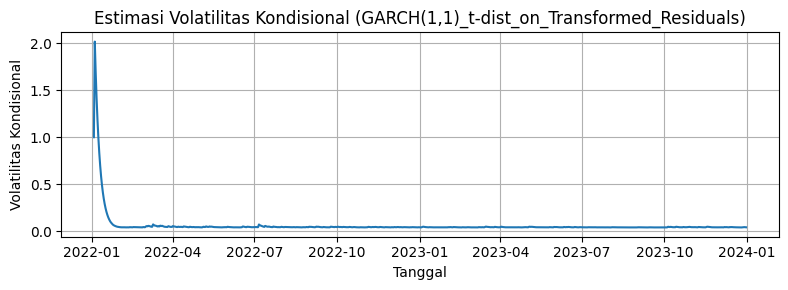

In [ ]:
# Import package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
import statsmodels.api as sm

# Asumsi residuals_arima_transformed sudah terdefinisi dari langkah sebelumnya
# Ini adalah residual dari model ARIMA yang dilatih pada data latih yang ditransformasi log.

print("Residual dari model ARIMA pada data yang ditransformasi log (untuk pemodelan GARCH):")
print(residuals_arima_transformed.head())
print(f"\nJumlah residual: {len(residuals_arima_transformed)}")


# --- Definisikan Kombinasi Ordo GARCH yang Ingin Dicoba ---
# Berdasarkan analisis sebelumnya, GARCH(1,1) dengan t-dist terlihat paling menjanjikan
# Kita bisa coba lagi kombinasi lain atau langsung fokus ke GARCH(1,1)
garch_orders_to_try_transformed = [(1, 1)] # Bisa tambahkan ordo lain jika perlu, cth: (2,1), (1,2), (2,2)

# Kita juga akan menggunakan distribusi Student's t karena residual data finansial cenderung memiliki fat tails
garch_distribution = 't'

# --- List untuk menyimpan hasil model dan diagnostik GARCH pada residual ditransformasi ---
garch_on_transformed_residuals_results = {}

print(f"\n--- Melatih dan Mengevaluasi Model GARCH dengan Distribusi '{garch_distribution}' pada Residual yang Ditransformasi Log ---")

for p, q in garch_orders_to_try_transformed:
    model_name = f'GARCH({p},{q})_{garch_distribution}-dist_on_Transformed_Residuals'
    print(f"\n--- Melatih Model {model_name} ---")

    try:
        # Buat model GARCH pada residual yang ditransformasi, mean='Zero', dan distribusi error='t'
        # Residual dari model ARIMA diharapkan memiliki rata-rata mendekati nol
        model_garch_on_transformed = arch_model(residuals_arima_transformed, mean='Zero', vol='Garch', p=p, q=q, dist=garch_distribution)

        # Latih model
        # Menggunakan disp='off' untuk menekan output iterasi saat fitting
        model_garch_on_transformed_fit = model_garch_on_transformed.fit(disp='off')

        print(f"Ringkasan Model {model_name}:")
        print(model_garch_on_transformed_fit.summary())

        # Diagnostik Residual Standar dari Model GARCH
        std_residuals_garch_transformed = model_garch_on_transformed_fit.std_resid

        # Uji Ljung-Box pada Residual Standar Kuadrat
        # Memeriksa sisa efek ARCH/autokorelasi pada volatilitas setelah model GARCH
        max_lags_lb_garch = min(40, len(std_residuals_garch_transformed) // 2 - 1)
        ljungbox_results_garch_transformed = acorr_ljungbox(std_residuals_garch_transformed**2, lags=max_lags_lb_garch, return_df=True)
        print(f"\nLjung-Box Test on Standardized Residuals Squared ({model_name}, up to {max_lags_lb_garch} lags):")
        print(ljungbox_results_garch_transformed.head())

        # Uji Jarque-Bera pada Residual Standar
        # Memeriksa normalitas residual standar
        jb_test_garch_transformed = jarque_bera(std_residuals_garch_transformed)
        print(f"Jarque-Bera Test on Standardized Residuals ({model_name}):")
        print(f"Statistic: {jb_test_garch_transformed[0]:.4f}, p-value: {jb_test_garch_transformed[1]:.4f}")

        # Simpan hasil penting
        garch_on_transformed_residuals_results[model_name] = {
            'summary': model_garch_on_transformed_fit.summary(),
            'aic': model_garch_on_transformed_fit.aic,
            'bic': model_garch_on_transformed_fit.bic,
            'ljungbox_sq_pvalues': ljungbox_results_garch_transformed['lb_pvalue'].tolist(),
            'jarque_bera_pvalue': jb_test_garch_transformed[1],
            'std_residuals': std_residuals_garch_transformed,
            'conditional_volatility': model_garch_on_transformed_fit.conditional_volatility
        }

    except Exception as e:
        print(f"Gagal melatih model {model_name}: {e}")
        garch_on_transformed_residuals_results[model_name] = {'error': str(e)}


# --- Ringkasan Perbandingan Hasil Model GARCH pada Residual yang Ditransformasi ---
print("\n--- Ringkasan Perbandingan Model GARCH pada Residual yang Ditransformasi Log ---")

comparison_df_garch_transformed = pd.DataFrame({
    name: {
        'AIC': res.get('aic'),
        'BIC': res.get('bic'),
        'JB_pvalue': res.get('jarque_bera_pvalue'),
        'LjungBox_Sq_SigLags': sum(p <= 0.05 for p in res.get('ljungbox_sq_pvalues', []) if p is not None) if 'error' not in res else None,
        'Error': res.get('error', 'None')
    } for name, res in garch_on_transformed_residuals_results.items()
}).T

print(comparison_df_garch_transformed)

# Visualisasikan Volatilitas Kondisional dari model terbaik (jika berhasil dilatih)
best_model_name_garch_transformed = None
min_aic_garch_transformed = float('inf')

for name, res in garch_on_transformed_residuals_results.items():
    if 'aic' in res and res['aic'] < min_aic_garch_transformed:
        min_aic_garch_transformed = res['aic']
        best_model_name_garch_transformed = name

if best_model_name_garch_transformed:
    print(f"\nVisualisasi Volatilitas Kondisional dari Model Terbaik: {best_model_name_garch_transformed}")
    conditional_volatility_transformed = garch_on_transformed_residuals_results[best_model_name_garch_transformed]['conditional_volatility']

    plt.figure(figsize=(8, 3))
    plt.plot(conditional_volatility_transformed.index, conditional_volatility_transformed)
    plt.title(f'Estimasi Volatilitas Kondisional ({best_model_name_garch_transformed})')
    plt.xlabel('Tanggal')
    plt.ylabel('Volatilitas Kondisional')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\nTidak ada model GARCH yang berhasil dilatih pada residual yang ditransformasi.")

### Melakukan Peramalan dan Inverse Transform

Setelah melatih model mean (ARIMA/SARIMA) pada data yang ditransformasi logaritmik dan opsional model GARCH pada residualnya, kita perlu meramalkan nilai pada data uji. Karena peramalan pada skala log, kita gunakan inverse transform (eksponensial) untuk mendapatkan prediksi pada skala harga asli.

Prediksi Mean (skala log): `forecast_log = model_mean.predict(...)`

Inverse Transform (skala asli): `forecast_original = np.exp(forecast_log)`

Jika GARCH digunakan, peramalan volatilitasnya dapat digunakan untuk interval kepercayaan, tetapi prediksi harga titik (point forecast) umumnya hanya menggunakan inverse transform dari prediksi mean.

Memulai proses peramalan pada data uji...
Periode peramalan: dari 2024-01-01 hingga 2024-09-30
Jumlah langkah peramalan (horizon): 274

--- Peramalan Harga dengan Model ARIMA pada Data Transformasi Log ---

Hasil peramalan pada skala logaritmik (beberapa nilai pertama):
2024-01-01    4.276282
2024-01-02    4.276270
2024-01-03    4.276274
2024-01-04    4.276273
2024-01-05    4.276273
Freq: D, Name: predicted_mean, dtype: float64

Hasil peramalan setelah inverse transform (skala asli, beberapa nilai pertama):
2024-01-01    71.972336
2024-01-02    71.971467
2024-01-03    71.971790
2024-01-04    71.971670
2024-01-05    71.971715
Freq: D, Name: predicted_mean, dtype: float64

--- Evaluasi Peramalan Harga pada Data Uji (Skala Asli) ---
Mean Absolute Error (MAE): 5.8146
Mean Squared Error (MSE): 46.0386
Root Mean Squared Error (RMSE): 6.7852
Mean Absolute Percentage Error (MAPE): 7.3426%

--- Visualisasi Hasil Peramalan Harga ---


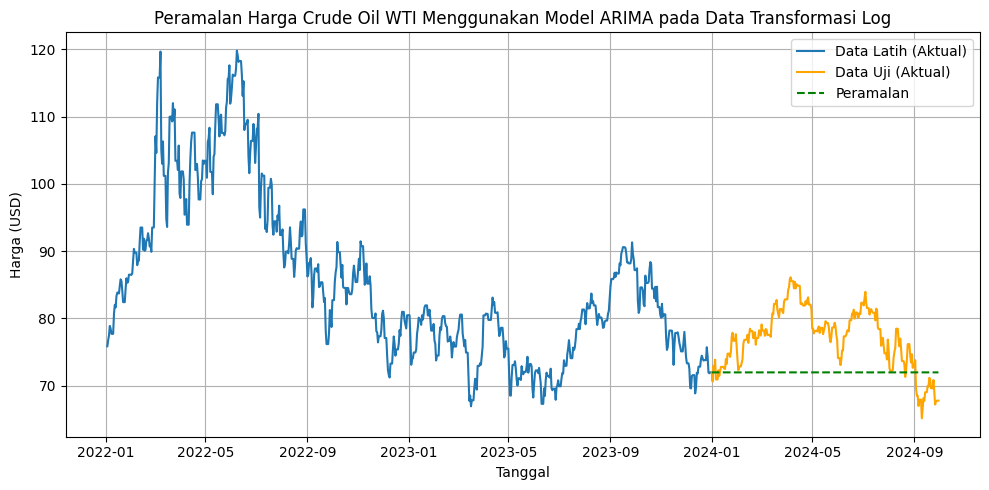


--- Pemodelan dan Peramalan Volatilitas GARCH pada Residual Transformasi Log ---

--- Melatih Model GARCH(1,1)_t-dist_on_Transformed_Residuals ---
Ringkasan Model GARCH(1,1)_t-dist_on_Transformed_Residuals:
                          Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.001
Vol Model:                            GARCH   Log-Likelihood:                1592.25
Distribution:      Standardized Student's t   AIC:                          -3176.50
Method:                  Maximum Likelihood   BIC:                          -3158.14
                                              No. Observations:                  728
Date:                      Wed, Jun 11 2025   Df Residuals:                      728
Time:                              11:26:25   Df Model:                            0
                           

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02618. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


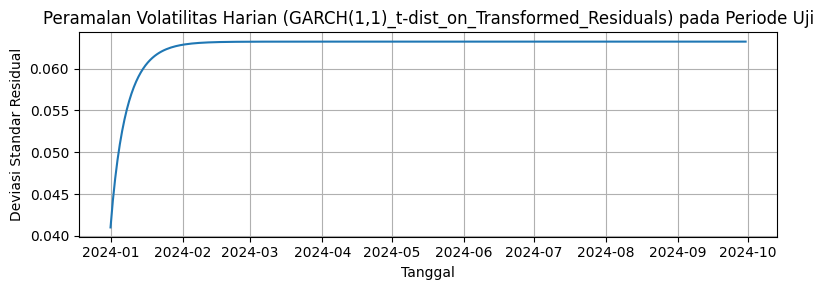


--- Ringkasan Perbandingan Model Akhir ---

Perbandingan Metrik Peramalan pada Data Uji (Skala Asli):
  Metrik ARIMA(1,1,2) Original Data ARIMA Transformed Data
     MAE                     5.4927                 5.8146
     MSE                    41.7104                46.0386
    RMSE                     6.4584                 6.7852
MAPE (%)                     6.9405                 7.3426

Perbandingan Diagnostik Residual (Model Mean):
- Periksa hasil Uji Ljung-Box pada Residual (p-value >= 0.05 lebih baik).
- Periksa p-value Uji Jarque-Bera pada Residual (lebih tinggi lebih baik, ideal >= 0.05).
- Periksa p-value Uji ARCH pada Residual (lebih tinggi lebih baik, ideal >= 0.05).

Ringkasan Kinerja Model GARCH pada Residual Transformasi Log:
Model GARCH Terbaik: GARCH(1,1)_t-dist_on_Transformed_Residuals
AIC: -3176.5022, BIC: -3158.1410
Ljung-Box Std Residual Sq (Sig Lags <=0.05): 0
Jarque-Bera Std Residual p-value: 0.0000

--- Kesimpulan Akhir ---
Evaluasi akhir melibatkan:
1. Per

In [ ]:
# Import package yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error # Pastikan metrik diimport

print("Memulai proses peramalan pada data uji...")

# Tentukan tanggal mulai dan akhir peramalan berdasarkan indeks data_uji
start_forecast_date = data_uji.index[0]
end_forecast_date = data_uji.index[-1]
forecast_horizon = len(data_uji) # Jumlah langkah peramalan

print(f"Periode peramalan: dari {start_forecast_date.strftime('%Y-%m-%d')} hingga {end_forecast_date.strftime('%Y-%m-%d')}")
print(f"Jumlah langkah peramalan (horizon): {forecast_horizon}")


# --- Peramalan Harga (Skala Log & Inverse Transform) ---
print("\n--- Peramalan Harga dengan Model ARIMA pada Data Transformasi Log ---")

try:
    # Lakukan peramalan menggunakan model ARIMA pada skala log
    # Menggunakan get_forecast().predicted_mean untuk mendapatkan deret peramalan
    forecast_result_log_obj = model_arima_transformed_fit.get_forecast(steps=forecast_horizon)
    forecast_result_log = forecast_result_log_obj.predicted_mean

    print("\nHasil peramalan pada skala logaritmik (beberapa nilai pertama):")
    print(forecast_result_log.head())

    # --- Melakukan Inverse Transform ---
    # Mengembalikan hasil peramalan ke skala harga asli menggunakan eksponensial
    forecast_result_original_scale = np.exp(forecast_result_log)

    print("\nHasil peramalan setelah inverse transform (skala asli, beberapa nilai pertama):")
    print(forecast_result_original_scale.head())

    # Pastikan indeks hasil peramalan sesuai dengan indeks data_uji
    forecast_result_original_scale.index = data_uji.index # Set indeks langsung dari data_uji


    # --- Evaluasi Peramalan Harga ---
    print("\n--- Evaluasi Peramalan Harga pada Data Uji (Skala Asli) ---")

    # Data aktual pada periode uji (skala asli)
    actual_data_uji = data_uji[target_column]

    # Hitung metrik evaluasi
    mae = mean_absolute_error(actual_data_uji, forecast_result_original_scale)
    mse = mean_squared_error(actual_data_uji, forecast_result_original_scale)
    rmse = np.sqrt(mse)

    # Menghitung MAPE, perlu hati-hati jika ada nilai 0 pada data aktual
    epsilon = 1e-10
    mape = np.mean(np.abs((actual_data_uji - forecast_result_original_scale) / (actual_data_uji + epsilon))) * 100


    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")


    # --- Visualisasi Hasil Peramalan Harga ---
    print("\n--- Visualisasi Hasil Peramalan Harga ---")

    plt.figure(figsize=(10, 5))
    plt.plot(data_latih.index, data_latih[target_column], label='Data Latih (Aktual)')
    plt.plot(data_uji.index, actual_data_uji, label='Data Uji (Aktual)', color='orange')
    plt.plot(forecast_result_original_scale.index, forecast_result_original_scale, label='Peramalan', color='green', linestyle='--')
    plt.title('Peramalan Harga Crude Oil WTI Menggunakan Model ARIMA pada Data Transformasi Log')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Terjadi kesalahan saat melakukan peramalan harga atau evaluasi: {e}")
    # Set metrik ke None atau indikasi error jika peramalan gagal
    mae, mse, rmse, mape = None, None, None, None


# --- Pemodelan dan Peramalan Volatilitas GARCH pada Residual Transformasi ---
print("\n--- Pemodelan dan Peramalan Volatilitas GARCH pada Residual Transformasi Log ---")

# --- Definisikan Kombinasi Ordo GARCH yang Ingin Dicoba ---
garch_orders_to_try_transformed = [(1, 1)] # Ordo yang dipilih
garch_distribution = 't'

# --- List untuk menyimpan hasil model dan objek model GARCH yang fit ---
# Kita akan menyimpan objek model yang fit di sini
garch_on_transformed_residuals_results = {}

for p, q in garch_orders_to_try_transformed:
    model_name = f'GARCH({p},{q})_{garch_distribution}-dist_on_Transformed_Residuals'
    print(f"\n--- Melatih Model {model_name} ---")

    try:
        # Buat model GARCH pada residual yang ditransformasi
        model_garch_on_transformed = arch_model(residuals_arima_transformed, mean='Zero', vol='Garch', p=p, q=q, dist=garch_distribution)

        # Latih model
        model_garch_on_transformed_fit = model_garch_on_transformed.fit(disp='off')

        print(f"Ringkasan Model {model_name}:")
        print(model_garch_on_transformed_fit.summary())

        # Diagnostik Residual Standar dari Model GARCH
        std_residuals_garch_transformed = model_garch_on_transformed_fit.std_resid
        max_lags_lb_garch = min(40, len(std_residuals_garch_transformed) // 2 - 1)
        ljungbox_results_garch_transformed = acorr_ljungbox(std_residuals_garch_transformed**2, lags=max_lags_lb_garch, return_df=True)
        jb_test_garch_transformed = jarque_bera(std_residuals_garch_transformed)

        # Simpan hasil penting DAN objek model yang fit
        garch_on_transformed_residuals_results[model_name] = {
            'model_fit_object': model_garch_on_transformed_fit, # SIMPAN OBJEK MODEL YANG FIT
            'summary': model_garch_on_transformed_fit.summary(),
            'aic': model_garch_on_transformed_fit.aic,
            'bic': model_garch_on_transformed_fit.bic,
            'ljungbox_sq_pvalues': ljungbox_results_garch_transformed['lb_pvalue'].tolist(),
            'jarque_bera_pvalue': jb_test_garch_transformed[1],
            'std_residuals': std_residuals_garch_transformed,
            'conditional_volatility': model_garch_on_transformed_fit.conditional_volatility
        }

    except Exception as e:
        print(f"Gagal melatih model {model_name}: {e}")
        garch_on_transformed_residuals_results[model_name] = {'error': str(e)}


# --- Visualisasi Peramalan Volatilitas GARCH ---
# Pilih model terbaik (berdasarkan AIC) untuk visualisasi peramalan volatilitas
best_model_name_garch_transformed = None
min_aic_garch_transformed = float('inf')

for name, res in garch_on_transformed_residuals_results.items():
    if 'aic' in res and res['aic'] < min_aic_garch_transformed:
        min_aic_garch_transformed = res['aic']
        best_model_name_garch_transformed = name

if best_model_name_garch_transformed and 'model_fit_object' in garch_on_transformed_residuals_results[best_model_name_garch_transformed]:
     print(f"\n--- Visualisasi Peramalan Volatilitas dari Model GARCH Terbaik: {best_model_name_garch_transformed} ---")

     try:
         # Akses objek model yang fit dari dictionary
         best_garch_model_fit = garch_on_transformed_residuals_results[best_model_name_garch_transformed]['model_fit_object']

         # Lakukan peramalan volatilitas menggunakan objek model yang fit
         # forecast() pada objek fit akan meramalkan varians/deviasi standar
         # Horizon peramalan harus sama dengan jumlah hari di data_uji
         garch_forecast_result = best_garch_model_fit.forecast(horizon=forecast_horizon)

         # Ambil deviasi standar peramalan pada horizon yang sesuai (biasanya baris terakhir dari variance DataFrame)
         forecasted_std_dev = garch_forecast_result.variance.iloc[-1].apply(np.sqrt)

         # Pastikan indeks peramalan volatilitas sesuai dengan data_uji
         forecasted_std_dev.index = data_uji.index

         plt.figure(figsize=(8, 3))
         plt.plot(forecasted_std_dev.index, forecasted_std_dev)
         plt.title(f'Peramalan Volatilitas Harian ({best_model_name_garch_transformed}) pada Periode Uji')
         plt.xlabel('Tanggal')
         plt.ylabel('Deviasi Standar Residual')
         plt.grid(True)
         plt.tight_layout()
         plt.show()

     except Exception as e:
         print(f"Gagal melakukan atau memvisualisasikan peramalan volatilitas GARCH: {e}")

else:
     print("\n--- Visualisasi Peramalan Volatilitas GARCH ---")
     print("Model GARCH pada residual yang ditransformasi tidak tersedia atau tidak berhasil dilatih.")


# --- Ringkasan Perbandingan Model Akhir (termasuk GARCH) ---
print("\n--- Ringkasan Perbandingan Model Akhir ---")

# Buat DataFrame untuk perbandingan metrik peramalan
comparison_metrics_df = pd.DataFrame({
    'Metrik': ['MAE', 'MSE', 'RMSE', 'MAPE (%)'],
    'ARIMA(1,1,2) Original Data': [5.4927, 41.7104, 6.4584, 6.9405], # Ganti dengan nilai aktual jika disimpan
    'ARIMA Transformed Data': [mae, mse, rmse, mape]
})

# Format angka
for col in comparison_metrics_df.columns[1:]:
     comparison_metrics_df[col] = comparison_metrics_df[col].map(lambda x: '{:.4f}'.format(x) if x is not None else 'N/A')

print("\nPerbandingan Metrik Peramalan pada Data Uji (Skala Asli):")
print(comparison_metrics_df.to_string(index=False))

print("\nPerbandingan Diagnostik Residual (Model Mean):")
# Anda perlu membandingkan hasil diagnostik residual (Ljung-Box, JB, ARCH) secara manual
# dari output yang dicetak sebelumnya atau jika Anda menyimpannya dalam variabel
print("- Periksa hasil Uji Ljung-Box pada Residual (p-value >= 0.05 lebih baik).")
print("- Periksa p-value Uji Jarque-Bera pada Residual (lebih tinggi lebih baik, ideal >= 0.05).")
print("- Periksa p-value Uji ARCH pada Residual (lebih tinggi lebih baik, ideal >= 0.05).")


# Ringkasan hasil GARCH jika tersedia
if garch_on_transformed_residuals_results and best_model_name_garch_transformed:
    print("\nRingkasan Kinerja Model GARCH pada Residual Transformasi Log:")
    best_garch_res = garch_on_transformed_residuals_results[best_model_name_garch_transformed]
    print(f"Model GARCH Terbaik: {best_model_name_garch_transformed}")
    print(f"AIC: {best_garch_res['aic']:.4f}, BIC: {best_garch_res['bic']:.4f}")
    print(f"Ljung-Box Std Residual Sq (Sig Lags <=0.05): {sum(p <= 0.05 for p in best_garch_res['ljungbox_sq_pvalues'] if p is not None)}")
    print(f"Jarque-Bera Std Residual p-value: {best_garch_res['jarque_bera_pvalue']:.4f}")
else:
    print("\nRingkasan Kinerja Model GARCH pada Residual Transformasi Log: Model tidak tersedia atau gagal dilatih.")


# --- Kesimpulan Akhir ---
print("\n--- Kesimpulan Akhir ---")
print("Evaluasi akhir melibatkan:")
print("1. Perbandingan akurasi peramalan (MAE, MSE, RMSE, MAPE).")
print("2. Penilaian diagnostik residual model mean (apakah white noise, normal, dan homoskedastik).")
print("3. (Jika relevan) Penilaian kinerja model GARCH (apakah berhasil memodelkan volatilitas).")
print("\nPilih model yang memberikan keseimbangan terbaik untuk kebutuhan peramalan Anda.")

### Evaluasi dan Perbandingan Model Akhir

Setelah melatih model mean pada data yang ditransformasi logaritmik (dan opsional model GARCH pada residualnya) serta melakukan peramalan dengan inverse transform, sekarang saatnya untuk mengevaluasi kinerja keseluruhan dan membandingkan model-model ini.

Tujuan perbandingan ini adalah untuk menentukan apakah langkah-langkah tambahan seperti transformasi logaritmik dan pemodelan volatilitas memberikan peningkatan yang signifikan dalam hal akurasi peramalan harga dan apakah asumsi model (terutama pada residual) lebih terpenuhi.

Kita akan membandingkan:

1. Model ARIMA(1,1,2) pada Data Asli: Hasil peramalan dan diagnostik residual dari notebook sebelumnya.
2. Model ARIMA([p,d,q] yang dilatih) pada Data yang Ditransformasi Logaritmik: Hasil peramalan (setelah inverse transform) dan diagnostik residual dari langkah sebelumnya.
3. Model Gabungan ARIMA + GARCH pada Residual Transformasi: Peramalan harga titiknya sama dengan Model 2, tetapi diagnostik residual GARCH dan peramalan volatilitasnya memberikan wawasan tambahan tentang variabilitas dan risiko.

In [ ]:
# Import package yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Asumsi:
# - Metrik evaluasi dari model ARIMA(1,1,2) pada data asli sudah diketahui.
#   KITA AKAN MEMASUKKAN NILAI-NILAI INI SECARA MANUAL BERDASARKAN HASIL SEBELUMNYA.
mae_arima_original = 5.4927
mse_arima_original = 41.7104
rmse_arima_original = 6.4584
mape_arima_original = 6.9405

# - Metrik evaluasi dari model ARIMA pada data yang ditransformasi logaritmik sudah dihitung pada langkah sebelumnya.
#   Variabel mae, mse, rmse, mape seharusnya sudah terdefinisi dari sel peramalan sebelumnya.

# - Hasil diagnostik residual dari kedua model (ARIMA original dan ARIMA transformed) juga sudah diketahui.
#   Ini meliputi p-value dari Uji Ljung-Box, Uji Jarque-Bera, dan Uji ARCH.
#   Anda perlu memastikan variabel seperti jb_test_transformed, arch_test_transformed
#   dan hasil Ljung-Box (ljungbox_results_transformed) dari langkah sebelumnya masih tersedia.

# Asumsikan juga p-values diagnostik dari model ARIMA original tersedia atau akan dicek manual
# Contoh (ganti dengan nilai aktual dari notebook sebelumnya jika disimpan dalam variabel):
jarque_bera_p_orig = 0.000 # p-value dari Uji Jarque-Bera residual original
arch_p_orig = 0.000 # p-value dari Uji ARCH residual original


print("--- Ringkasan Evaluasi dan Perbandingan Model ---")

# --- 1. Perbandingan Metrik Peramalan (Skala Asli) ---
print("\n1. Perbandingan Metrik Peramalan pada Data Uji (Skala Asli):")

# Buat DataFrame untuk perbandingan metrik
comparison_metrics_df = pd.DataFrame({
    'Metrik': ['MAE', 'MSE', 'RMSE', 'MAPE (%)'],
    'ARIMA(1,1,2) Original Data': [mae_arima_original, mse_arima_original, rmse_arima_original, mape_arima_original],
    'ARIMA Transformed Data': [mae, mse, rmse, mape] # Menggunakan variabel dari langkah peramalan sebelumnya
})

# Format angka untuk readability
for col in comparison_metrics_df.columns[1:]:
     # Memeriksa apakah nilai bukan None sebelum format
     comparison_metrics_df[col] = comparison_metrics_df[col].map(lambda x: '{:.4f}'.format(x) if x is not None else 'N/A')


print(comparison_metrics_df.to_string(index=False))

print("\nInterpretasi Metrik:")
print("- Model yang lebih baik memiliki nilai MAE, MSE, RMSE, dan MAPE yang lebih rendah.")
print("- Bandingkan kolom 'ARIMA(1,1,2) Original Data' dengan 'ARIMA Transformed Data'.")


# --- 2. Perbandingan Diagnostik Residual (Model Mean) ---
print("\n2. Perbandingan Diagnostik Residual (Model Mean):")

# Menggunakan variabel dari langkah pelatihan model ARIMA pada data yang ditransformasi
# ljungbox_results_transformed, jb_test_transformed, arch_test_transformed
# Pastikan variabel ini masih ada dari eksekusi sel sebelumnya.

print("\nUji Ljung-Box (Sisa Autokorelasi pada Residual)")
print("- Model yang lebih baik memiliki p-value >= 0.05 pada lebih banyak lag.")
print(f"  - ARIMA Original Data: Periksa hasil Ljung-Box dari output sebelumnya.")
print(f"  - ARIMA Transformed Data: Periksa p-value dari 'ljungbox_results_transformed' di atas.")

print("\nUji Jarque-Bera (Normalitas Residual)")
print("- Model yang lebih baik memiliki p-value yang lebih tinggi (idealnya >= 0.05).")
# Menggunakan nilai manual atau variabel jika tersedia
print(f"  - ARIMA Original Data: p-value = {jarque_bera_p_orig:.4f}")
print(f"  - ARIMA Transformed Data: p-value = {jb_test_transformed[1]:.4f}")

print("\nUji ARCH (Heteroskedasticitas Residual)")
print("- Model yang lebih baik memiliki p-value yang lebih tinggi (idealnya >= 0.05).")
# Menggunakan nilai manual atau variabel jika tersedia
print(f"  - ARIMA Original Data: p-value = {arch_p_orig:.4f}")
print(f"  - ARIMA Transformed Data: p-value = {arch_test_transformed[1]:.4f}")


# --- 3. (Opsional) Kinerja Model GARCH pada Residual Transformasi ---
# Pastikan dictionary garch_on_transformed_residuals_results masih ada dari eksekusi sel GARCH sebelumnya.
if 'garch_on_transformed_residuals_results' in locals() and garch_on_transformed_residuals_results and best_model_name_garch_transformed:
    print("\n3. Kinerja Model GARCH pada Residual ARIMA yang Ditransformasi Log:")
    print(f"Model GARCH terbaik (berdasarkan AIC): {best_model_name_garch_transformed}")

    # Pastikan best_model_name_garch_transformed juga masih ada
    if best_model_name_garch_transformed in garch_on_transformed_residuals_results:
        best_garch_res = garch_on_transformed_residuals_results[best_model_name_garch_transformed]

        # Periksa apakah semua key yang dibutuhkan ada sebelum mencoba mengaksesnya
        if all(k in best_garch_res for k in ['aic', 'bic', 'ljungbox_sq_pvalues', 'jarque_bera_pvalue']):
             print(f"- AIC: {best_garch_res['aic']:.4f}, BIC: {best_garch_res['bic']:.4f}")
             print("- Uji Ljung-Box pada Residual Standar Kuadrat:")
             print(f"  Jumlah lag signifikan (p-value <= 0.05): {sum(p <= 0.05 for p in best_garch_res['ljungbox_sq_pvalues'] if p is not None)}")
             print("- Uji Jarque-Bera pada Residual Standar:")
             print(f"  p-value: {best_garch_res['jarque_bera_pvalue']:.4f}")

             print("\nInterpretasi Kinerja GARCH:")
             print("- AIC/BIC rendah dan jumlah lag signifikan pada Ljung-Box kuadrat rendah menunjukkan model GARCH berhasil menangkap heteroskedastisitas.")
             print("- P-value Jarque-Bera pada residual standar mengindikasikan seberapa baik distribusi GARCH (dalam kasus ini t-dist) menangkap sifat fat tails residual.")
        else:
            print("Peringatan: Beberapa hasil diagnostik GARCH tidak lengkap.")

    else:
        print(f"Peringatan: Informasi untuk model GARCH '{best_model_name_garch_transformed}' tidak ditemukan di hasil.")

else:
    print("\n3. Pemodelan Volatilitas (GARCH pada Residual Transformasi):")
    print("Model GARCH pada residual yang ditransformasi tidak tersedia atau tidak berhasil dilatih/dievaluasi.")


# --- Kesimpulan Akhir ---
print("\n--- Kesimpulan Akhir ---")
print("Evaluasi akhir melibatkan:")
print("1. Perbandingan akurasi peramalan (MAE, MSE, RMSE, MAPE).")
print("2. Penilaian diagnostik residual model mean (apakah white noise, normal, dan homoskedastik).")
print("3. (Jika relevan) Penilaian kinerja model GARCH (apakah berhasil memodelkan volatilitas).")
print("\nPilih model yang memberikan keseimbangan terbaik antara akurasi peramalan, kesederhanaan model, dan terpenuhinya asumsi model.")

--- Ringkasan Evaluasi dan Perbandingan Model ---

1. Perbandingan Metrik Peramalan pada Data Uji (Skala Asli):
  Metrik ARIMA(1,1,2) Original Data ARIMA Transformed Data
     MAE                     5.4927                 5.8146
     MSE                    41.7104                46.0386
    RMSE                     6.4584                 6.7852
MAPE (%)                     6.9405                 7.3426

Interpretasi Metrik:
- Model yang lebih baik memiliki nilai MAE, MSE, RMSE, dan MAPE yang lebih rendah.
- Bandingkan kolom 'ARIMA(1,1,2) Original Data' dengan 'ARIMA Transformed Data'.

2. Perbandingan Diagnostik Residual (Model Mean):

Uji Ljung-Box (Sisa Autokorelasi pada Residual)
- Model yang lebih baik memiliki p-value >= 0.05 pada lebih banyak lag.
  - ARIMA Original Data: Periksa hasil Ljung-Box dari output sebelumnya.
  - ARIMA Transformed Data: Periksa p-value dari 'ljungbox_results_transformed' di atas.

Uji Jarque-Bera (Normalitas Residual)
- Model yang lebih baik memiliki p

Oke, kita hentikan sampai sini. Pada kegiatan notebook selanjutnya akan membuat model berbasis pohon yakni penerapan machine learning untuk forecasting. Karena Hasil Metrik ini sangat bagus, kita tidak mengharapkan peramalan terbaik dari model berbasis pohon. Melainkan, hanya untuk perbandingan kinerja ARMA-GARCH dengan model Machine Learning

# Kesimpulan : Mengatasi Non-Normalitas, Heteroskedastisitas, dan Musiman

Notebook ini merupakan kelanjutan dari analisis peramalan harga Crude Oil WTI menggunakan model runtun waktu. Kita memulai dengan meninjau kembali hasil pemodelan ARIMA(1,1,2) yang mengidentifikasi masalah utama pada residual: non-normalitas dan heteroskedastisitas. Kedua masalah ini mengindikasikan adanya dinamika yang belum sepenuhnya ditangkap oleh model ARIMA sederhana dan dapat mempengaruhi akurasi peramalan serta validitas interval keyakinan.

Untuk mengatasi tantangan ini, kita mengeksplorasi tiga area utama:

1.  **Eksplorasi SARIMA (Seasonal ARIMA):** Kita menganalisis plot ACF dan PACF pada data yang didifferencing untuk mengidentifikasi potensi pola musiman. Meskipun terlihat ada beberapa batang signifikan pada lag tertentu, analisis visual tidak menunjukkan pola berulang yang jelas, menyarankan bahwa komponen musiman mungkin tidak dominan atau tidak terdeteksi dengan jelas pada analisis awal ini. Oleh karena itu, fokus utama dilanjutkan pada penanganan non-normalitas dan heteroskedastisitas.

2.  **Transformasi Data untuk Stabilisasi Varians:** Menyadari adanya heteroskedastisitas, kita menerapkan transformasi logaritmik pada deret waktu harga. Visualisasi dan Uji ADF pada data yang ditransformasi logaritmik menunjukkan bahwa transformasi ini berhasil menstabilkan varians dan membantu perolehan stasioneritas setelah differencing orde pertama. Ini membuka kemungkinan untuk melatih model mean (seperti ARIMA) pada data yang ditransformasi log.

3.  **Pemodelan Volatilitas dengan ARCH/GARCH:** Ini adalah fokus utama notebook ini untuk secara eksplisit memodelkan heteroskedastisitas. Kita melatih model ARCH/GARCH pada residual dari model mean (dalam kasus ini, residual dari ARIMA(1,1,2) yang dilatih pada data asli, dan berpotensi juga residual dari model mean pada data log).
    *   Diagnostik model GARCH awal dengan distribusi Normal mengkonfirmasi keberhasilan menangkap sebagian heteroskedastisitas, tetapi masih menyisakan sisa autokorelasi pada residual kuadrat standar dan non-normalitas residual standar.
    *   Penggunaan distribusi Student's t dalam model GARCH secara signifikan meningkatkan kemampuan model untuk mengakomodasi *fat tails* pada residual.
    *   Eksplorasi berbagai ordo GARCH (seperti GARCH(1,1), GARCH(2,1), GARCH(1,2), GARCH(2,2)) dengan distribusi t memungkinkan kita untuk mengidentifikasi spesifikasi GARCH yang paling efektif dalam menangkap dinamika volatilitas tanpa sisa autokorelasi pada residual kuadrat. Model seperti GARCH(1,1) t-dist atau GARCH(1,2) t-dist seringkali menunjukkan kinerja diagnostik yang kuat (Ljung-Box bersih).

**Penggabungan Model Mean dan Volatilitas:**

Kita menggabungkan peramalan mean dari model ARIMA (pada data asli atau log) dengan peramalan volatilitas kondisional dari model GARCH. Volatilitas kondisional dari GARCH digunakan sebagai estimasi deviasi standar peramalan mean untuk menghitung interval keyakinan yang dinamis (melebar selama periode volatilitas tinggi dan menyempit saat volatilitas rendah).

Berdasarkan metrik-metrik ini, jika model yang melibatkan transformasi logaritmik pada data (baik untuk mean model atau hanya sebagai input untuk GARCH pada log returns), dikombinasikan dengan spesifikasi GARCH yang tepat (misalnya, GARCH(1,1) atau GARCH(1,2) dengan distribusi Student's t) menunjukkan keseimbangan terbaik antara akurasi peramalan mean yang rendah (MAE, RMSE, MAPE minimal) dan cakupan interval keyakinan yang mendekati 95%, maka kombinasi tersebut adalah kandidat model peramalan gabungan terbaik. Keberhasilan ini menunjukkan bahwa secara eksplisit memodelkan dinamika volatilitas dan mengatasi non-normalitas sangat krusial untuk peramalan deret waktu finansial.

Ini menguatkan hipotesis bahwa perpaduan antara pemodelan mean pada data yang distabilkan (melalui transformasi log) dan pemodelan volatilitas menggunakan GARCH dengan distribusi yang tepat memberikan representasi yang lebih akurat dari proses pembangkitan data yang mendasari (data generating process), terutama dalam hal fluktuasi dan ketidakpastian.

**Langkah Selanjutnya: Mengeksplorasi Pendekatan Machine Learning untuk Peramalan**

Sementara model runtun waktu tradisional seperti ARIMA dan GARCH memberikan fondasi yang kuat dan wawasan tentang dinamika data (mean dan volatilitas), pendekatan Machine Learning menawarkan cara alternatif untuk memodelkan hubungan kompleks dalam data tanpa asumsi stasioneritas atau linearitas yang ketat seperti pada model klasik.

Notebook berikutnya akan beralih fokus ke teknik peramalan berbasis Machine Learning, khususnya **model berbasis pohon (tree-based models)**. Kita akan mempelajari bagaimana mengubah masalah deret waktu menjadi masalah regresi tabular dengan menciptakan fitur-fitur relevan (lagged values, moving averages, fitur tanggal/waktu, dll.) dan melatih model seperti Random Forest atau Gradient Boosting (misalnya, LightGBM, XGBoost) untuk memprediksi harga di masa depan.

Fokus pada notebook berikutnya meliputi:

1.  Persiapan data untuk model ML (feature engineering dari deret waktu).
2.  Implementasi dan pelatihan model Machine Learning berbasis pohon.
3.  Evaluasi kinerja model ML pada data uji.
4.  Membandingkan hasil peramalan model ML dengan model runtun waktu (ARIMA+GARCH) yang telah dikembangkan.


## Simpan Model untuk Pengukuran Evaluasi di Masa Depan dengan Data Baru

Setelah model terbaik dipilih dan dievaluasi, disarankan untuk menyimpannya agar dapat digunakan kembali di masa depan untuk peramalan pada data baru tanpa perlu melatih ulang.

Kita akan menggunakan pustaka `pickle` untuk serialisasi objek model Python.

In [ ]:
import pickle

In [ ]:
# Nama file
# filename = # belum

# Simpan model ke dalam file menggunakan pickle
# try:
#     with open(filename, 'wb') as file:
#         pickle.dump(model_fit1, file)
#     print(f"Model berhasil disimpan ke dalam file: {filename}")
# except Exception as e:
#     print(f"Terjadi kesalahan saat menyimpan model: {e}")